# Feature Importance

## Admin/NOTES:



- Possible things to add:
    - Walk through selecting the figure aesthetics?
        - See `-1_Figure Settings.ipynb` and `lp_styles.py`
    -  I think there is content from week 2 about seaborn's context (and matplotlib styles?) in week 2 we could move to here/the additional lessons mentioned above.

## Lesson Objectives

By the end of this lesson, students will be able to:
- Explain what feature importance is, which models use it, and what it means.
- Visualize and construct recommendations using feature importance.
- Use scikit-learn v1.1's simplified toolkit.
- Implement scikit-learn's permutation_importance, and its advantages over built-in importance.

## Improved Scikit-Learn Version 
- This stack, we will be focusing on extracting insights from our models: both by examining parameters/aspects of the model itself, like the coefficients it calculated, but also by applying some additional tools and packages specifically designed to explain models. 

- Scikit-learn recently released version 1.1.1, which added several helpful tools that will simplify our workflow. Specifically, it will make it much easier to extract all of our feature names after processing. This will make it easier to visualize and interpret the insights our models can provide.

- Let's review some of the key differences using sklearn v1.1+!

### Confirming Package Versions

- All packages have a version number that indicates which iteration of the package is currently being used.
    - If you import an entire package, you can use the special method `package.__version__` (replace package with the name of the package you want to check).
- The reason this is important is that as of the writing of this stack, Google Colab is still using a version of python that is too old to support the newest scikit-learn.
    - You can check which version of python you are using by running the following command in a jupyter notebook:
        - `!python --version`
        - Note: if you remove the `!`, you can run this command in your terminal.

- If you run the following code on Google Colab and on your local computer, you can compare the version numbers. 
        
<img src="images/colab_versions.png" width=400px>

- Now, run the following block of code in a jupyter notebook on your local machine to confirm that you have Python 3.8.13 and sklearn v1.1.1.




In [1]:
# Run the following command on your local computer to 
import sklearn
!python --version
print(f"sklearn version: {sklearn.__version__}")

Python 3.8.13
sklearn version: 1.1.2



>- If you have a Python 3.7 or an earlier version of scikit-learn, please revisit the "Data Science Python Installation" chapter. 
<!--     - See the "`Updating Your Dojo-Env Lesson` [Note to Brenda: does not exist yet - see 1:1 doc for question on handling multiple envs] for how to remove your current dojo-env and replace it with the new one. -->

## Highlighted Changes  - scikit-learn v1.1

- The single biggest change in the updated sklearn is a fully-functional `.get_feature_names_out()` method in the `ColumnTransformer`.
    - This will make it MUCH easier for us to extract our transformed data as dataframes and to match up the feature names to our models' coefficients.
    
- A sklearn-wide change that you may notice is that our models and preprocessing tools look much nicer than they used to! Sklearn used to use text-based representations for its objects, but it has switched to "diagram" based representations by default.

    <img src="images/diagram_example.png" width=300x>
- The default diagrams should be fine for most situations, but if you need to switch back to the former text-based displays you can use the `set_config` function in sklearn.
```python
# set text displays for sklearn
from sklearn import set_config
set_config(display='text')
```
    - Note: if you'd like to see diagram representations on Google Colab, you can use the same function to activate them, just change `display="text"` to `display="diagram"`
- There are some additional updates that are not pertinent to this stack, but if you are curious, you can find the [details on the new release here](https://scikit-learn.org/stable/auto_examples/release_highlights/plot_release_highlights_1_1_0.html).

In [2]:
## You do not need to do this, but it text is best for the LP
from sklearn import set_config
set_config(display='text')

### Preprocessing with Sklearn V1.1

- Thankfully, none of our sklearn imports have changed, just some of the features of the tools we use.

In [3]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer


## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)

In [5]:
## SETTING CUSTOM STYLES - ASK BRENDA ABOUT IF/HOW TO INCLUDE
from lp_styles import *

In [6]:
## Load in the student performance - portugese dataset & display the head and info
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vS6xDKNpWkBBdhZSqepy48bXo55QnRv1Xy6tXTKYzZLMPjZozMfYhHQjAcC8uj9hQ/pub?output=xlsx"

df = pd.read_excel(url,sheet_name='student-por')
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      649 non-null    object 
 1   sex         649 non-null    object 
 2   age         649 non-null    float64
 3   address     649 non-null    object 
 4   famsize     649 non-null    object 
 5   Pstatus     649 non-null    object 
 6   Medu        649 non-null    float64
 7   Fedu        649 non-null    float64
 8   Mjob        649 non-null    object 
 9   Fjob        649 non-null    object 
 10  reason      649 non-null    object 
 11  guardian    649 non-null    object 
 12  traveltime  649 non-null    float64
 13  studytime   649 non-null    float64
 14  failures    649 non-null    float64
 15  schoolsup   649 non-null    object 
 16  famsup      649 non-null    object 
 17  paid        649 non-null    object 
 18  activities  649 non-null    object 
 19  nursery     649 non-null    o

school sex   age address famsize Pstatus  Medu  Fedu     Mjob     Fjob  ...  \
0     GP   F  18.0       U     GT3       A   4.0   4.0  at_home  teacher  ...   
1     GP   F  17.0       U     GT3       T   1.0   1.0  at_home    other  ...   
2     GP   F  15.0       U     LE3       T   1.0   1.0  at_home    other  ...   

  famrel freetime  goout  Dalc  Walc health absences    G1    G2    G3  
0    4.0      3.0    4.0   1.0   1.0    3.0      4.0   0.0  11.0  11.0  
1    5.0      3.0    3.0   1.0   1.0    3.0      2.0   9.0  11.0  11.0  
2    4.0      3.0    2.0   2.0   3.0    3.0      6.0  12.0  13.0  12.0  

[3 rows x 33 columns]

- Notice that we cannot see all of columns in our `df.head()`:
    - Pandas truncates the display in the middle and displays `...` instead. 
- We can get around this by changing the settings in Pandas using `pd.set_option`
    - In this case, we want to change the `max_columns` to be a number larger than our number of final features, to allow for more features being added during One Hot Encoding. Since we have 33 features, setting the `max_columns` to 50 should be sufficient.
- For more information on pandas options, see their [documentation on Options and Settings](https://pandas.pydata.org/docs/user_guide/options.html)
- Final note: in your project notebooks, you should add this function to the top of your notebook right after your imports.

In [7]:
## Using pd.set_option to display more columns
pd.set_option('display.max_columns',50)
df.head(3)

school sex   age address famsize Pstatus  Medu  Fedu     Mjob     Fjob  \
0     GP   F  18.0       U     GT3       A   4.0   4.0  at_home  teacher   
1     GP   F  17.0       U     GT3       T   1.0   1.0  at_home    other   
2     GP   F  15.0       U     LE3       T   1.0   1.0  at_home    other   

   reason guardian  traveltime  studytime  failures schoolsup famsup paid  \
0  course   mother         2.0        2.0       0.0       yes     no   no   
1  course   father         1.0        2.0       0.0        no    yes   no   
2   other   mother         1.0        2.0       0.0       yes     no   no   

  activities nursery higher internet romantic  famrel  freetime  goout  Dalc  \
0         no     yes    yes       no       no     4.0       3.0    4.0   1.0   
1         no      no    yes      yes       no     5.0       3.0    3.0   1.0   
2         no     yes    yes      yes       no     4.0       3.0    2.0   2.0   

   Walc  health  absences    G1    G2    G3  
0   1.0     3.0       4.0   0.0  11.0  11.0  
1   1.0     3.0       2.0   9.0  11.0  11.0  
2   3.0     3.0       6.0  12.0  13.0  12.0

### Selecting Our Features

- If we wanted to make recommendations to the school district on how to identify and help students that will perform poorly by year 3, we should think about what features make the most sense to include.

- There are ~2 different approaches  we could take to what to include, depending on what use case we are addressing for our stakeholder.

For example, if our primary goal is to just identify 3rd year students that will perform poorly, then including all of these features would make sense.

However, if our primary goal is to identify which INCOMING students will perform poorly by their 3rd year, then we would NOT include G1 or G2, since the school will not have those grades for bran new incoming students.

- We will start our analysis addressing the first use case, identify rising 3rd year students that will perform poorly.

### Train Test Split

In [8]:
## Make x and y variables
y = df['G3'].copy()
X = df.drop(columns=['G3']).copy()

## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)
X_train.head()

school sex   age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
54      GP   F  15.0       U     LE3       A   3.0   3.0    other     other   
208     GP   M  16.0       U     GT3       T   2.0   3.0    other     other   
23      GP   M  16.0       U     LE3       T   2.0   2.0    other     other   
547     MS   M  16.0       R     LE3       T   4.0   1.0    other   at_home   
604     MS   F  18.0       U     GT3       T   1.0   1.0  at_home  services   

         reason guardian  traveltime  studytime  failures schoolsup famsup  \
54        other   mother         1.0        1.0       0.0        no     no   
208        home   father         2.0        1.0       0.0        no     no   
23   reputation   mother         2.0        2.0       0.0        no    yes   
547       other   father         1.0        1.0       0.0        no     no   
604      course   mother         3.0        2.0       1.0        no     no   

    paid activities nursery higher internet romantic  famrel  freetime  goout  \
54    no         no     yes    yes      yes       no     5.0       3.0    4.0   
208   no         no     yes    yes      yes       no     5.0       3.0    3.0   
23    no        yes     yes    yes      yes       no     5.0       4.0    4.0   
547   no         no     yes    yes      yes       no     4.0       1.0    2.0   
604   no         no     yes     no       no       no     4.0       4.0    2.0   

     Dalc  Walc  health  absences    G1    G2  
54    4.0   4.0     1.0       0.0  13.0  12.0  
208   1.0   1.0     3.0       0.0  13.0  12.0  
23    2.0   4.0     5.0       2.0  10.0  10.0  
547   2.0   1.0     2.0       0.0  10.0  11.0  
604   1.0   2.0     2.0       2.0   9.0  10.0

### Preprocessing + ColumnTransformer

In [9]:
## make categorical selector and verifying it works 
cat_sel = make_column_selector(dtype_include='object')
cat_sel(X_train)

['school',
 'sex',
 'address',
 'famsize',
 'Pstatus',
 'Mjob',
 'Fjob',
 'reason',
 'guardian',
 'schoolsup',
 'famsup',
 'paid',
 'activities',
 'nursery',
 'higher',
 'internet',
 'romantic']

In [10]:
## make numeric selector and verifying it works 
num_sel = make_column_selector(dtype_include='number')
num_sel(X_train)

['age',
 'Medu',
 'Fedu',
 'traveltime',
 'studytime',
 'failures',
 'famrel',
 'freetime',
 'goout',
 'Dalc',
 'Walc',
 'health',
 'absences',
 'G1',
 'G2']

In [11]:
## make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))

num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

> Nothing we have done yet should be new code. The changes we will make will be when we create our ColumnTransformer with `make_column_transformer`.
- From now on, you should add `verbose_feature_names_out=False` to `make_column_transformer`

In [12]:
## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x163dfc640>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x163dd6f40>)],
                  verbose_feature_names_out=False)

>- In order to extract the feature names from the preprocessor, we first have to fit it on the data.
- Next, we can use the `preprocessor.get_feature_names_out()` method and save the output as something like "feature_names" or "final_features".

In [13]:
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
       'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health',
       'absences', 'G1', 'G2', 'school_GP', 'school_MS', 'sex_F', 'sex_M',
       'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3',
       'Pstatus_A', 'Pstatus_T', 'Mjob_at_home', 'Mjob_health',
       'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home',
       'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher',
       'reason_course', 'reason_home', 'reason_other',
       'reason_reputation', 'guardian_father', 'guardian_mother',
       'guardian_other', 'schoolsup_no', 'schoolsup_yes', 'famsup_no',
       'famsup_yes', 'paid_no', 'paid_yes', 'activities_no',
       'activities_yes', 'nursery_no', 'nursery_yes', 'higher_no',
       'higher_yes', 'internet_no', 'internet_yes', 'romantic_no',
       'romantic_yes'], dtype=object)

- Notice how we were able to get the complete list of feature names, including the One Hot Encoded features with their proper prefixes. 
- Quick note: if you forgot to add `verbose_feature_names_out` when you made your preprocessor, you would get something like this:


In [14]:
## make the preprocessing column transformer
preprocessor_oops = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel)
                                           ) # forgot verbose_feature_names_out=False
## fit column transformer and run get_feature_names_out
preprocessor_oops.fit(X_train)
feature_names_oops = preprocessor_oops.get_feature_names_out()
feature_names_oops

array(['pipeline-1__age', 'pipeline-1__Medu', 'pipeline-1__Fedu',
       'pipeline-1__traveltime', 'pipeline-1__studytime',
       'pipeline-1__failures', 'pipeline-1__famrel',
       'pipeline-1__freetime', 'pipeline-1__goout', 'pipeline-1__Dalc',
       'pipeline-1__Walc', 'pipeline-1__health', 'pipeline-1__absences',
       'pipeline-1__G1', 'pipeline-1__G2', 'pipeline-2__school_GP',
       'pipeline-2__school_MS', 'pipeline-2__sex_F', 'pipeline-2__sex_M',
       'pipeline-2__address_R', 'pipeline-2__address_U',
       'pipeline-2__famsize_GT3', 'pipeline-2__famsize_LE3',
       'pipeline-2__Pstatus_A', 'pipeline-2__Pstatus_T',
       'pipeline-2__Mjob_at_home', 'pipeline-2__Mjob_health',
       'pipeline-2__Mjob_other', 'pipeline-2__Mjob_services',
       'pipeline-2__Mjob_teacher', 'pipeline-2__Fjob_at_home',
       'pipeline-2__Fjob_health', 'pipeline-2__Fjob_other',
       'pipeline-2__Fjob_services', 'pipeline-2__Fjob_teacher',
       'pipeline-2__reason_course', 'pipeline-2__r

### Remaking Our X_train and X_test as DataFrames

- Now that we have our list of feature names, we can very easily transform out X_train and X_test into preprocessed dataframes. 
- We can immediately turn the output of our preprocessor into a dataframe and do not need to save it as a separate variable first.
    - Therefore, in our pd.DataFrame, we will provide the `preprocessor.transform(X_train)` as the first argument, followed by `columns=feature_names` (the list we extracted from our precprocessor)
    - Pro Tip: you can also use the same index as your X_train or X_test variable, if you want to match up one of the transformed rows with the original dataframe.

In [15]:
X_train_df = pd.DataFrame(preprocessor.transform(X_train), 
                          columns = feature_names, index = X_train.index)
X_train_df.head(3)

age  Medu  Fedu  traveltime  studytime  failures  famrel  freetime  \
54   15.0   3.0   3.0         1.0        1.0       0.0     5.0       3.0   
208  16.0   2.0   3.0         2.0        1.0       0.0     5.0       3.0   
23   16.0   2.0   2.0         2.0        2.0       0.0     5.0       4.0   

     goout  Dalc  Walc  health  absences    G1    G2  school_GP  school_MS  \
54     4.0   4.0   4.0     1.0       0.0  13.0  12.0        1.0        0.0   
208    3.0   1.0   1.0     3.0       0.0  13.0  12.0        1.0        0.0   
23     4.0   2.0   4.0     5.0       2.0  10.0  10.0        1.0        0.0   

     sex_F  sex_M  address_R  address_U  famsize_GT3  famsize_LE3  Pstatus_A  \
54     1.0    0.0        0.0        1.0          0.0          1.0        1.0   
208    0.0    1.0        0.0        1.0          1.0          0.0        0.0   
23     0.0    1.0        0.0        1.0          0.0          1.0        0.0   

     Pstatus_T  ...  Fjob_services  Fjob_teacher  reason_course  reason_home  \
54         0.0  ...            0.0           0.0            0.0          0.0   
208        1.0  ...            0.0           0.0            0.0          1.0   
23         1.0  ...            0.0           0.0            0.0          0.0   

     reason_other  reason_reputation  guardian_father  guardian_mother  \
54            1.0                0.0              0.0              1.0   
208           0.0                0.0              1.0              0.0   
23            0.0                1.0              0.0              1.0   

     guardian_other  schoolsup_no  schoolsup_yes  famsup_no  famsup_yes  \
54              0.0           1.0            0.0        1.0         0.0   
208             0.0           1.0            0.0        1.0         0.0   
23              0.0           1.0            0.0        0.0         1.0   

     paid_no  paid_yes  activities_no  activities_yes  nursery_no  \
54       1.0       0.0            1.0             0.0         0.0   
208      1.0       0.0            1.0             0.0         0.0   
23       1.0       0.0            0.0             1.0         0.0   

     nursery_yes  higher_no  higher_yes  internet_no  internet_yes  \
54           1.0        0.0         1.0          0.0           1.0   
208          1.0        0.0         1.0          0.0           1.0   
23           1.0        0.0         1.0          0.0           1.0   

     romantic_no  romantic_yes  
54           1.0           0.0  
208          1.0           0.0  
23           1.0           0.0  

[3 rows x 58 columns]

In [16]:
X_test_df = pd.DataFrame(preprocessor.transform(X_test), 
                          columns = feature_names, index = X_test.index)
X_test_df.head(3)

age  Medu  Fedu  traveltime  studytime  failures  famrel  freetime  \
104  15.0   3.0   4.0         1.0        2.0       0.0     5.0       4.0   
284  18.0   2.0   1.0         1.0        1.0       2.0     3.0       2.0   
579  18.0   1.0   3.0         1.0        1.0       0.0     4.0       3.0   

     goout  Dalc  Walc  health  absences    G1    G2  school_GP  school_MS  \
104    4.0   1.0   1.0     1.0       0.0  16.0  16.0        1.0        0.0   
284    5.0   2.0   5.0     5.0       4.0   7.0   8.0        1.0        0.0   
579    3.0   2.0   3.0     3.0       0.0   9.0  10.0        0.0        1.0   

     sex_F  sex_M  address_R  address_U  famsize_GT3  famsize_LE3  Pstatus_A  \
104    0.0    1.0        0.0        1.0          1.0          0.0        1.0   
284    0.0    1.0        0.0        1.0          1.0          0.0        0.0   
579    0.0    1.0        0.0        1.0          0.0          1.0        0.0   

     Pstatus_T  ...  Fjob_services  Fjob_teacher  reason_course  reason_home  \
104        0.0  ...            0.0           0.0            1.0          0.0   
284        1.0  ...            1.0           0.0            0.0          0.0   
579        1.0  ...            1.0           0.0            1.0          0.0   

     reason_other  reason_reputation  guardian_father  guardian_mother  \
104           0.0                0.0              0.0              1.0   
284           1.0                0.0              0.0              1.0   
579           0.0                0.0              0.0              1.0   

     guardian_other  schoolsup_no  schoolsup_yes  famsup_no  famsup_yes  \
104             0.0           1.0            0.0        0.0         1.0   
284             0.0           1.0            0.0        1.0         0.0   
579             0.0           1.0            0.0        1.0         0.0   

     paid_no  paid_yes  activities_no  activities_yes  nursery_no  \
104      1.0       0.0            0.0             1.0         0.0   
284      1.0       0.0            1.0             0.0         1.0   
579      1.0       0.0            1.0             0.0         0.0   

     nursery_yes  higher_no  higher_yes  internet_no  internet_yes  \
104          1.0        0.0         1.0          0.0           1.0   
284          0.0        1.0         0.0          0.0           1.0   
579          1.0        1.0         0.0          0.0           1.0   

     romantic_no  romantic_yes  
104          1.0           0.0  
284          1.0           0.0  
579          0.0           1.0  

[3 rows x 58 columns]

In [17]:
## confirm the first 3 rows index in y_test matches X_test_df
y_test.head(3)

104    16.0
284     6.0
579     9.0
Name: G3, dtype: float64

## Extracting Insights from Models - Feature Importance

- There are several different types of feature-specific values that are calculated by sklearn models and either are  used to predict the outcome (like Linear Regression coefficients) or to explain what features the model uses the most. 

- Tree-Based models (decision trees, random forests, xgboost, etc) can calculate what is called "feature importance".

- According to the [Scikit-Learn RandomForest Documentation on Feature Importance](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=randomforest#sklearn.ensemble.RandomForestClassifier.feature_importances_) "Feature Importance"is:
    - "The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance."
        - In other words, its how helpful each feature was in growing/sorting the tree-based model. The more helpful a feature was in separating the data. The more "important" it is. 
        
        

### Tree Based Models - Feature Importance

#### DecisionTreeRegressor

- Let's fit a vanilla DecisionTreeRegressor and get the r-squared value for the training and test data.
- We have a helpful regression evaluation below that we will use throughout this lesson.
    - It takes the model and the training and test X and y data. 
    - It will calculate R-squared and RMSE for both and print the scores. 

In [18]:
def evaluate_regression(model, X_train,y_train, X_test, y_test): 
    """Evaluates a scikit learn regression model using r-squared and RMSE"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")
    

In [19]:
reg = DecisionTreeRegressor(random_state=SEED)
reg.fit(X_train_df,y_train)
evaluate_regression(reg, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 1.00	RMSE= 0.00
Test Data:	R^2= 0.66	RMSE= 1.78


- As we can see above, our model is overfit to the training data (perfect R-quared of 1.0), with a test score of .87. 
    - Thankfully, the test score is still very high. 
    
- Note: We absolutely could tune the hyperparameters to reduce overfitting, but we can also use a RandomForest instead!
    - We will still have the same benefits of a DecisionTree but it is much less likely to overfit.

### RandomForestRegressor

In [20]:
reg = RandomForestRegressor(random_state=SEED)
reg.fit(X_train_df,y_train)
evaluate_regression(reg, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.98	RMSE= 0.52
Test Data:	R^2= 0.83	RMSE= 1.26


- Thats much better!
- Now let's see what our model used for predicting our target.

### Extracting Feature Importances

- For tree-based models in scikit-learn, we can find the feature importances under the `.feature_importances_` attribute. 
-  The `.feature_importances_` is a numpy matrix that should have the same number of values as the # of columns in X_train_df

In [21]:
reg.feature_importances_

array([9.06096804e-03, 4.27750617e-03, 3.98699965e-03, 7.00472751e-03,
       2.25626018e-03, 3.51399028e-03, 2.49268280e-03, 7.28098375e-03,
       5.16832208e-03, 7.96493073e-03, 3.65255869e-03, 3.45093237e-03,
       2.12456262e-02, 1.43357641e-02, 8.49691456e-01, 1.50552537e-03,
       1.34049006e-03, 8.01336123e-04, 2.00642049e-03, 9.16339891e-04,
       1.07877854e-03, 7.07605663e-04, 9.56989326e-04, 5.25321529e-04,
       3.57271546e-04, 7.24549353e-04, 4.69078763e-04, 1.72276703e-03,
       7.87754005e-04, 4.04612977e-03, 4.95701770e-04, 6.32101752e-04,
       2.02437914e-03, 2.64153718e-03, 2.88623322e-04, 1.66038340e-03,
       1.49827250e-03, 7.13793226e-03, 1.32903677e-03, 2.40072554e-03,
       1.19251978e-03, 6.59015769e-04, 1.29186344e-03, 1.17453508e-03,
       2.87137667e-03, 2.08767090e-03, 4.90905227e-04, 2.05326973e-04,
       6.07999604e-04, 6.08562065e-04, 1.09193794e-03, 1.09819114e-03,
       3.43745866e-04, 3.14073124e-04, 3.66951986e-04, 5.29971880e-04,
      

In [22]:
## Checking the number of feature importances matches the # of columns
print(len(reg.feature_importances_))
print(len(X_train_df.columns))

len(reg.feature_importances_) == len(X_train_df.columns)

58
58


True

### Saving the importances as a pandas Series

- We can immediately turn the the models' .feature_importances_ into a pd.Series, as well.
    - Therefore, in our pd.Series, we will provide the `reg.feature_importances_` as the first argument, followed by `index=feature_names` (instead of `columns=feature_names` pandas Series are 1D and do not have columns).
        - We also could use our `X_train_df.columns` to make our index, since they are the same as the `feature_names`
        
- (Optional) Adding a `name`. 
    - Pandas will use the name of a feature as the axis label when plotting with a Seried.

In [23]:
## Saving the feature importances
importances = pd.Series(reg.feature_importances_, index= feature_names,
                       name='Feature Importance')
importances

age                  0.009061
Medu                 0.004278
Fedu                 0.003987
traveltime           0.007005
studytime            0.002256
failures             0.003514
famrel               0.002493
freetime             0.007281
goout                0.005168
Dalc                 0.007965
Walc                 0.003653
health               0.003451
absences             0.021246
G1                   0.014336
G2                   0.849691
school_GP            0.001506
school_MS            0.001340
sex_F                0.000801
sex_M                0.002006
address_R            0.000916
address_U            0.001079
famsize_GT3          0.000708
famsize_LE3          0.000957
Pstatus_A            0.000525
Pstatus_T            0.000357
Mjob_at_home         0.000725
Mjob_health          0.000469
Mjob_other           0.001723
Mjob_services        0.000788
Mjob_teacher         0.004046
Fjob_at_home         0.000496
Fjob_health          0.000632
Fjob_other           0.002024
Fjob_servi

- As you can see, we now have a value for each feature used by our model.
    - the importances are all small values (below 1).
    - the importances sum up to 1 overall. 

In [24]:
importances.sum()

0.9999999999999999

- Let's visualize the feature importances  and then interpret what they are telling us.

### Visualizing Feature Importance

- Feature importances are always a positive value and there will be a subset of features with very high importances and a subset of features with very low importance. 
    - Let's try visualizing the values using  a horizontal barplot with pandas.

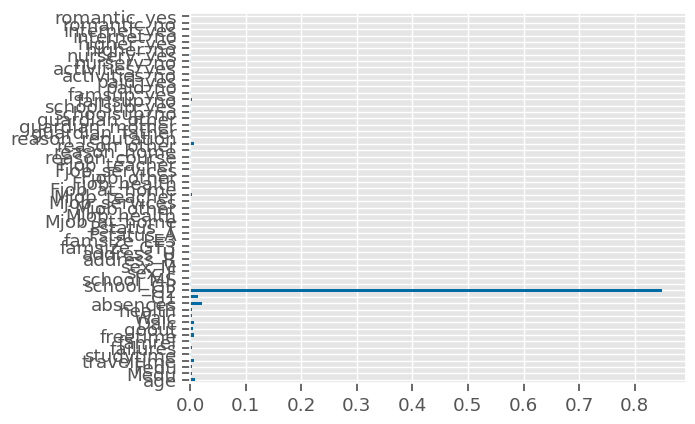

In [25]:
# plot importance
ax = importances.plot(kind='barh')

#### Considerations for Plotting Importances
- As we can (not really) see above, visualizing all of our feature importances with the default visualization options generally does not work very well.
- Issues with our visualization:
    1. Cannot read the feature names on the tick labels.
    2. Only a handful of features have visible bars.
    3. The bars that have similar importances are difficult to visually compare visually (which one is more important??)
    3. The graph is both small and wider than it needs to be. `[Rephrase?]`
    4. And of course, we have no axis labels or title.
    
    
#### Improving Our Visualization    
- **Let's visualize this again, but let's fix the issues we detailed above by:**
    1. Sorting our importances so that we plot them with the most important features on top. 
    2. Only plotting the a subset of the most important features.
    3. Specifying a taller and narrower figsize.
    4. And of course: adding labels and title
    -
        



##### A Note on Plotting the Top N Sorted Values
- We want to plot the 10 most important features with the 
- Your previous pandas experience would make you want to sort_values with ascending=False to get the more important features on top, and then to take the .head(10) and then using .plot().

Let's attempt this approach below.

In [26]:
## Savng the feature importances sorted from largest to smallest (ascending=False)
sorted_importance = importances.sort_values(ascending=False)
sorted_importance

G2                   0.849691
absences             0.021246
G1                   0.014336
age                  0.009061
Dalc                 0.007965
freetime             0.007281
reason_other         0.007138
traveltime           0.007005
goout                0.005168
Medu                 0.004278
Mjob_teacher         0.004046
Fedu                 0.003987
Walc                 0.003653
failures             0.003514
health               0.003451
famsup_no            0.002871
Fjob_services        0.002642
famrel               0.002493
guardian_father      0.002401
studytime            0.002256
famsup_yes           0.002088
Fjob_other           0.002024
sex_M                0.002006
Mjob_other           0.001723
reason_course        0.001660
school_GP            0.001506
reason_home          0.001498
school_MS            0.001340
reason_reputation    0.001329
schoolsup_no         0.001292
guardian_mother      0.001193
schoolsup_yes        0.001175
nursery_yes          0.001098
nursery_no

<AxesSubplot:>

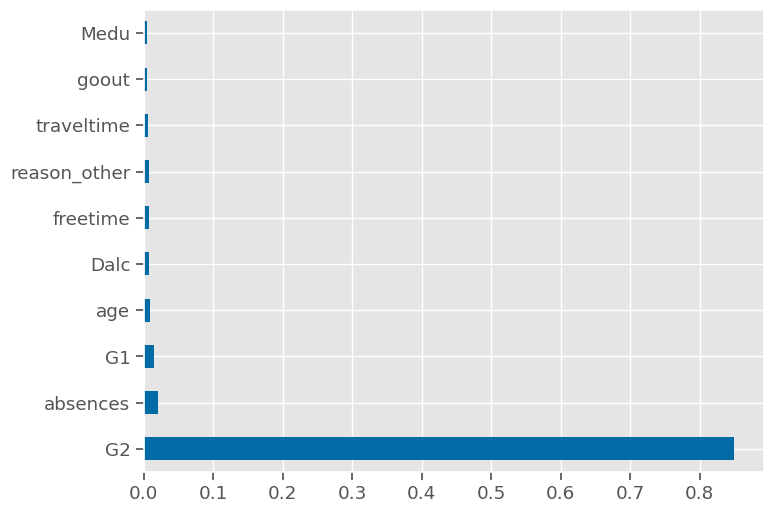

In [27]:
## just keep the top 10 importances and plot
sorted_importance.head(10).plot(kind='barh',
                                   figsize=(8,6))

- We have successfully plotted our top 10 feauture importances, but notice that the bars were actually plotted in the REVERSE order than we expected.

- For whatever reason, matplotlib plots bars in the opposite order as they are provided.
- To fix this:
    - We will use the default sorting for sort_values() and we will take the `.tail(10)` instead of `.head(10)`

<BarContainer object of 58 artists>

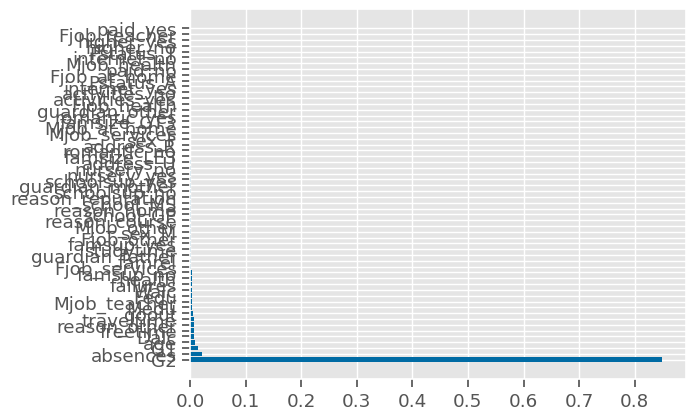

In [28]:
plt.barh(sorted_importance.index, sorted_importance.values)

In [29]:
## Savng the feature importances sorted from smallest to largest (ascending=True)
sorted_importance = importances.sort_values()
sorted_importance

paid_yes             0.000205
Fjob_teacher         0.000289
higher_yes           0.000314
higher_no            0.000344
Pstatus_T            0.000357
internet_no          0.000367
Mjob_health          0.000469
paid_no              0.000491
Fjob_at_home         0.000496
Pstatus_A            0.000525
internet_yes         0.000530
activities_no        0.000608
activities_yes       0.000609
Fjob_health          0.000632
guardian_other       0.000659
romantic_yes         0.000678
famsize_GT3          0.000708
Mjob_at_home         0.000725
Mjob_services        0.000788
sex_F                0.000801
address_R            0.000916
romantic_no          0.000948
famsize_LE3          0.000957
address_U            0.001079
nursery_no           0.001092
nursery_yes          0.001098
schoolsup_yes        0.001175
guardian_mother      0.001193
schoolsup_no         0.001292
reason_reputation    0.001329
school_MS            0.001340
reason_home          0.001498
school_GP            0.001506
reason_cou

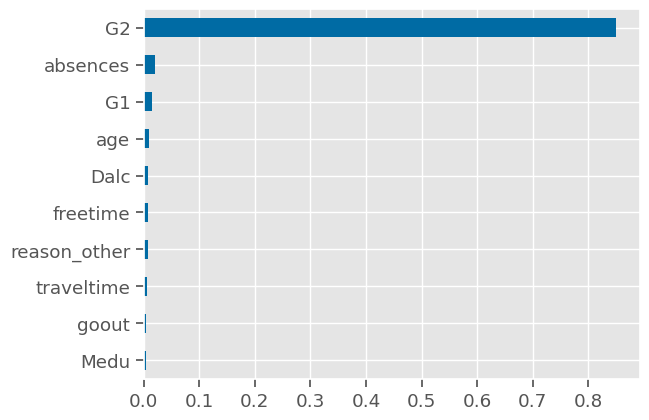

In [30]:
## just keep the top 10 importances and plot (that are at the bottom of our series)
ax = sorted_importance.tail(10).plot(kind='barh')

- Now, let's address the other issues with our visualization and save the figure as a variable. 
- We will interpret what it is telling us.

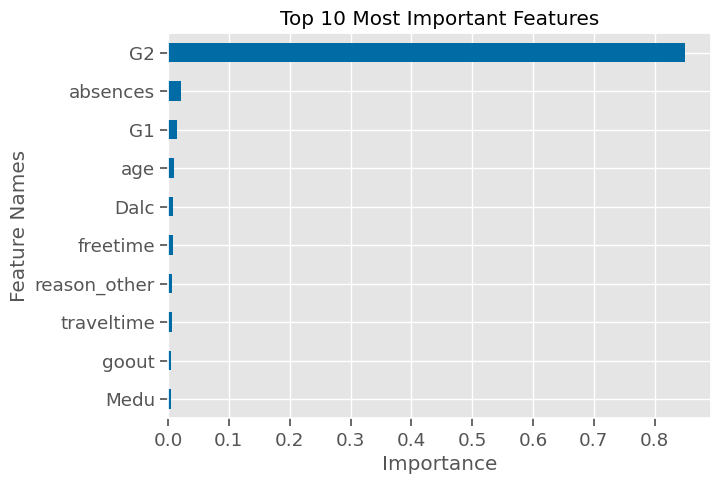

In [31]:
## plotting top 10 importances
ax = sorted_importance.tail(10).plot(kind='barh', 
                                   figsize=(7,5), 
                                     )
ax.set(xlabel='Importance', 
       ylabel='Feature Names', 
       title='Top 10 Most Important Features');

### `NOTE TO BRENDA`: Pandas .plot bug
- 1.4.2 has bug with .plot kind='barh' 
    - if provide an xlabel,it doesnt show up
    - solution is to add it afterwards via the aax
- will be fixed in v1.5 (current is 1.4.3)


### Note on saving Figures as a variables

- When we use pandas to make our visualization. It returns the `Axis` for the plot. 
    - As you can see immediately below, if we try to display the ax, we don't see anything!

In [32]:
## displaying the Axis
ax

<AxesSubplot:title={'center':'Top 10 Most Important Features'}, xlabel='Importance', ylabel='Feature Names'>

- To save the Figure, we can either:
    - use the `ax.get_figure()` method to extract it from our axis
    - OR running a special matplotlib function in the same cell that we create the graph. The function is called `plt.gcf()` (get current figure)
    
- `plt.gcf()` can be very helpful in  scenarios where we cannot easily get the figure that is produced by a plotting function in a python package.

In [33]:
## using the ax to get the fig
fig_ax = ax.get_figure()

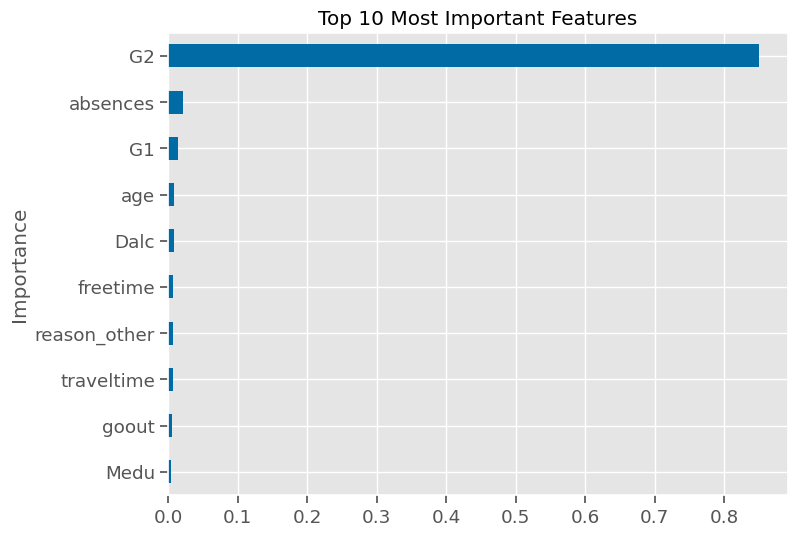

In [34]:
## Using plt.gcf to get the fig
ax = sorted_importance.tail(10).plot(kind='barh',
                                   figsize=(8,6), xlabel='Importance',
                                    ylabel='Feature Name', 
                                     title='Top 10 Most Important Features')
fig_gcf = plt.gcf()

- As we can see below, both methods of saving the fig produce the same result!

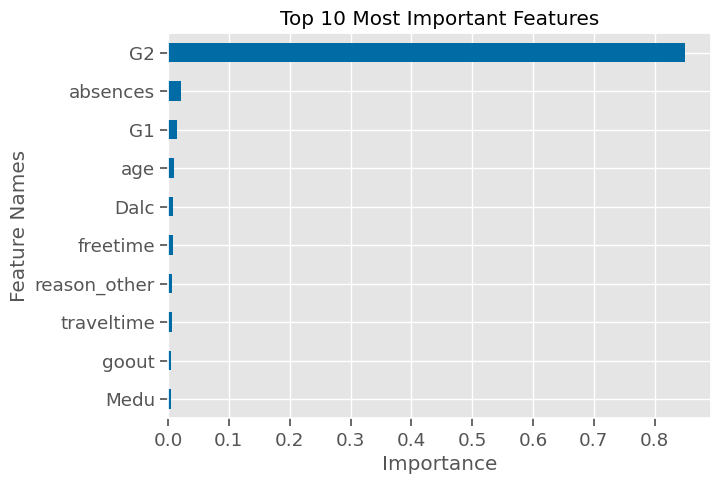

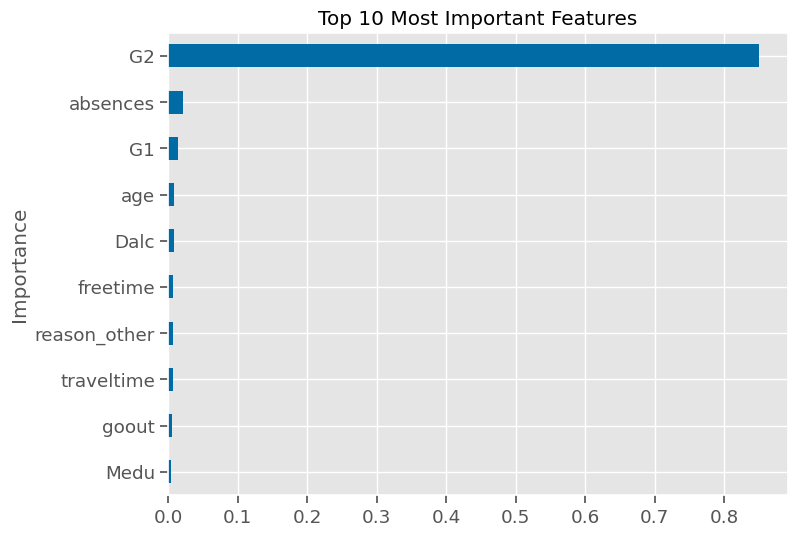

In [35]:
display(fig_ax, fig_gcf)

## Interpreting Feature Importance

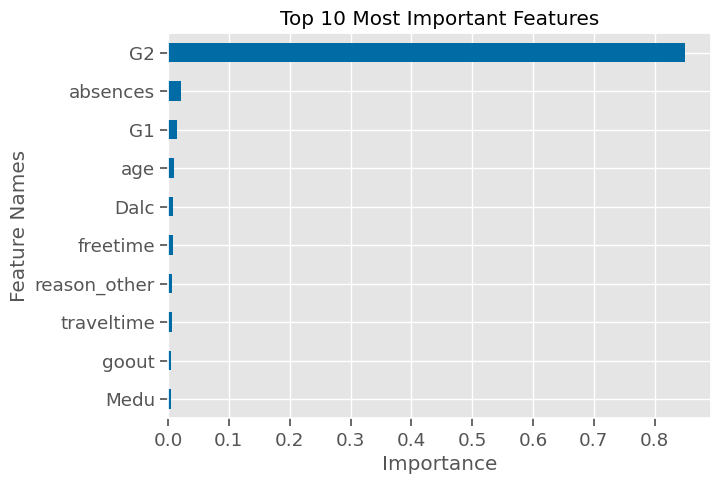

In [36]:
fig_ax

- **What the feature importances tell us:**
    - G2 is by far the single most important feature for predicting G3.
    - The # of absences is the second most important.
    - age, famrel, school_MS, goout have very minor importance.
    - Everything else is basically unimportant. 
    
> Note: we could actually use the feature importances to select which features we want to keep in our model!

- **What the feature importances don't tell us:**
    - Notice that all of the values on the graph are positive.
        - There is no +/- directionality with feature importance!
    - We only know that a feature was heavily used to predict the target, but we DON'T KNOW the actual **relationship** between the feature and target.
    - Does having a higher G2 mean higher G3?
    - Does more absences mean a higher G3?
    > We don't know!
    
    

### Defining a Function for Feature Importance 

- This is another process that we will want to easily repeat for future modes, so let's make a function for getting feature importance.

#### Function Considerations:
- We may or may not want to sort the features by importance.
- We may or may not want to plot the importances.
    - We may want to only plot the top N most important features. 
- In our current example, we already have the feature names saved as a variable called `feature_names`. But what about scenarios in which we don't have a variable for that?
    - The most convenient solution for this is the leverage the new model.feature_names_in_ attribute, which has the names of the training data memorized!

In [37]:
## extracting feature names from the model
reg.feature_names_in_

array(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
       'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health',
       'absences', 'G1', 'G2', 'school_GP', 'school_MS', 'sex_F', 'sex_M',
       'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3',
       'Pstatus_A', 'Pstatus_T', 'Mjob_at_home', 'Mjob_health',
       'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home',
       'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher',
       'reason_course', 'reason_home', 'reason_other',
       'reason_reputation', 'guardian_father', 'guardian_mother',
       'guardian_other', 'schoolsup_no', 'schoolsup_yes', 'famsup_no',
       'famsup_yes', 'paid_no', 'paid_yes', 'activities_no',
       'activities_yes', 'nursery_no', 'nursery_yes', 'higher_no',
       'higher_yes', 'internet_no', 'internet_yes', 'romantic_no',
       'romantic_yes'], dtype=object)

- Note: using None as a default argument for processes that we can calculate/extract if not provided. 

    - if we say `feature_names=None` in our function definition, we can then check if feature_names==None inside our function.
    - If its not None, then go ahead and use the provided feature names.
    - If it IS None: then extract them from the model using .feature_names_in_

In [38]:
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):
    
    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_
        
    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)
    
    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)
        
    return importances

In [39]:
def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"

    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"

    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance', 
           ylabel='Feature Names', 
           title=title)
    
    ## return ax in case want to continue to update/modify figure
    return ax

<AxesSubplot:title={'center':'All Features - Ranked by Importance'}, xlabel='Importance', ylabel='Feature Names'>

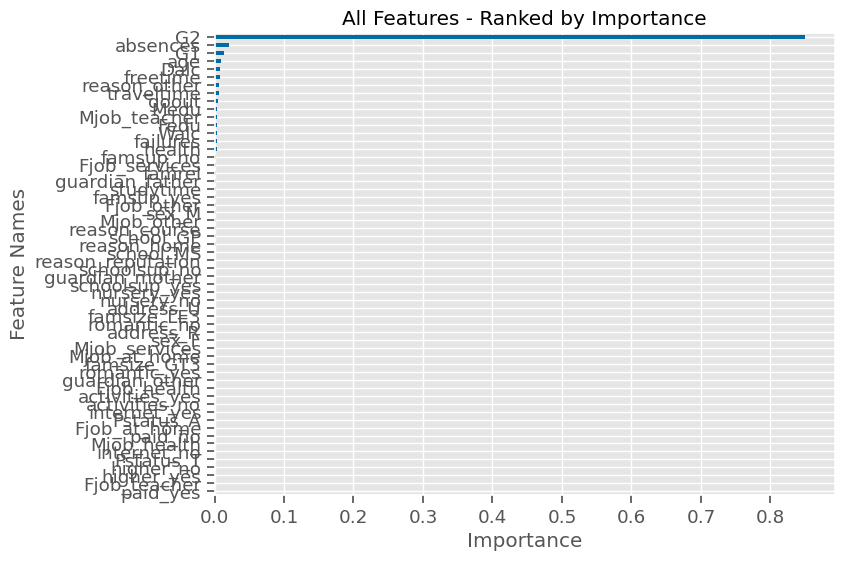

In [40]:
## testing our function
importances = get_importances(reg,sort=True,ascending=False)
plot_importance(importances)

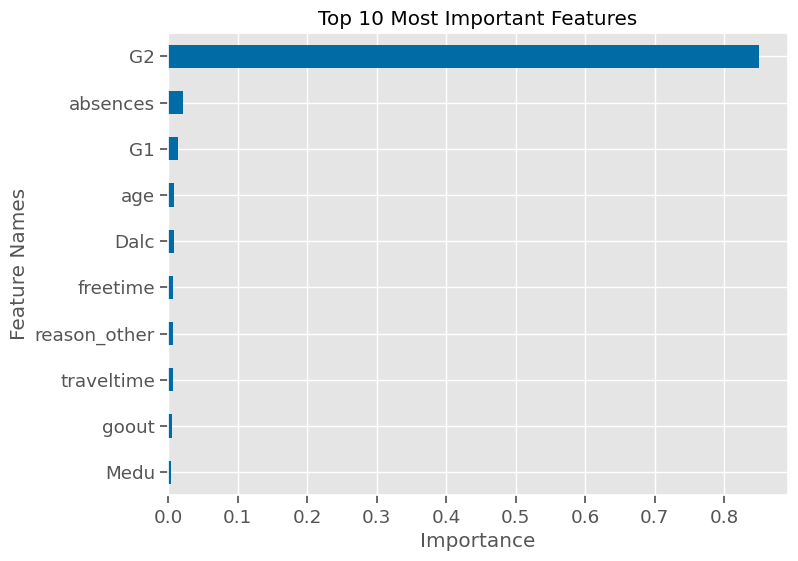

In [41]:
ax = plot_importance(importances,top_n=10)

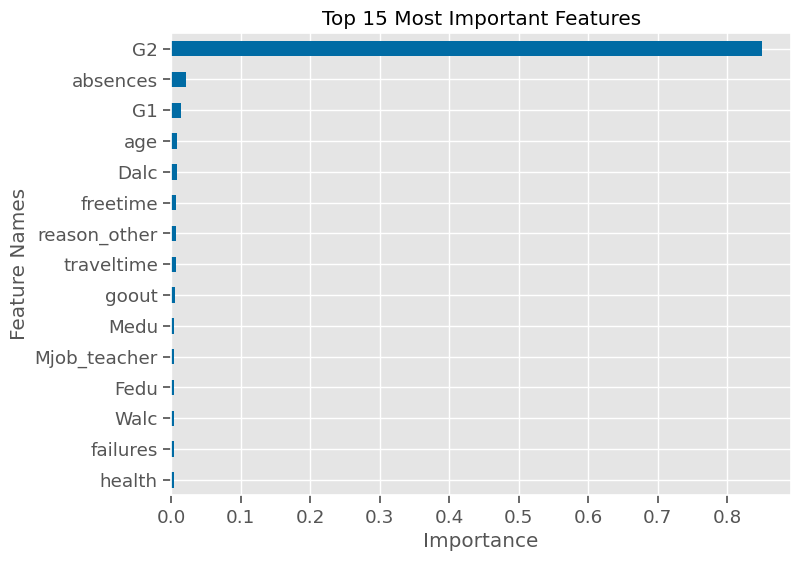

In [42]:
## testing our function
importances = get_importances(reg,sort=True,ascending=False,
                              name='RandomForest Importances')
plot_importance(importances,top_n=15);

### Remaking Our Model - Using Our Functions

- Now that we have 3 helpful functions for evaluating our model and visualizing feature importance, let's remake our previous model one more time.
- This time, we will use all 3 functions in the same cell as fitting our model. 

Training Data:	R^2= 0.98	RMSE= 0.52
Test Data:	R^2= 0.83	RMSE= 1.26


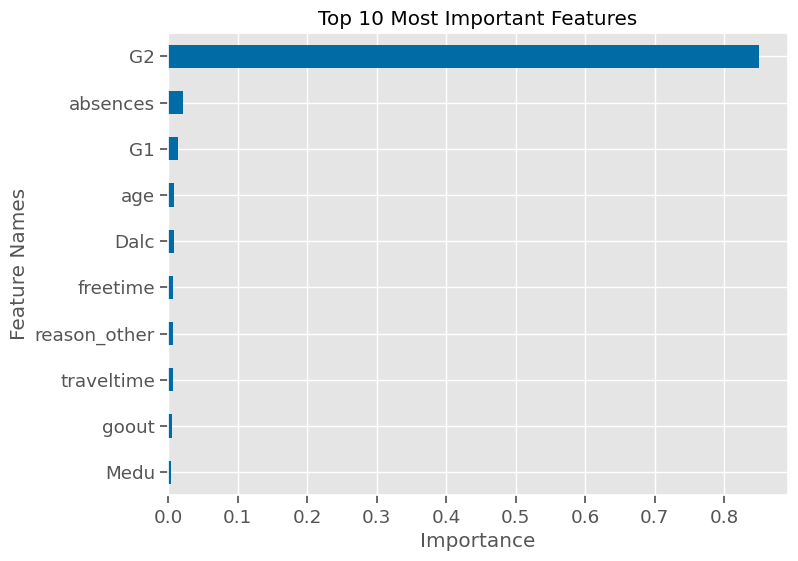

In [43]:
## fit random forest
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor()
reg.fit(X_train_df,y_train)
evaluate_regression(reg, X_train_df, y_train, X_test_df,y_test)

## Saving the feature importances
importances = get_importances(reg)
plot_importance(importances, top_n=10);

- Since feature importances sum to 1, if one feature is extremely important, the other features will only account for a very small amount of importance.
    - We have also discussed the 2 different approaches we could take with this business problem. We will remove the G1 and G2 features in our next model to try to predict student grades for year 3 without knowing their prior grades.
    

## **Visualizing Important Features**

- As we discussed when we introduced feature importance, we only know which features were used by the model to make its predictions, but we don't know the nature of the relationship between each feature.
- We will discuss additional tools we can apply to get more information about this relationship. But we can also use some EDA to explore the most important features and how they related to the target.

- Let's dive deeper into the 3 most important features used by our model.

In [44]:
importances.sort_values(ascending=False).head(3)

G2          0.849691
absences    0.021246
G1          0.014336
Name: Feature Importance, dtype: float64

- For each feature, let's pick an appropriate explanatory graph (based on the datatype), and let's visualize the `ORIG OR X?`

In [45]:
plot_train = pd.concat([X_train_df,y_train],axis=1)
plot_test = pd.concat([X_test_df,y_test],axis=1)
plot_df = pd.concat([plot_train, plot_test])
plot_df

age  Medu  Fedu  traveltime  studytime  failures  famrel  freetime  \
54   15.0   3.0   3.0         1.0        1.0       0.0     5.0       3.0   
208  16.0   2.0   3.0         2.0        1.0       0.0     5.0       3.0   
23   16.0   2.0   2.0         2.0        2.0       0.0     5.0       4.0   
547  16.0   4.0   1.0         1.0        1.0       0.0     4.0       1.0   
604  18.0   1.0   1.0         3.0        2.0       1.0     4.0       4.0   
..    ...   ...   ...         ...        ...       ...     ...       ...   
333  17.0   1.0   1.0         1.0        3.0       0.0     4.0       3.0   
454  16.0   1.0   2.0         1.0        3.0       1.0     1.0       3.0   
56   15.0   4.0   3.0         1.0        2.0       0.0     4.0       3.0   
203  17.0   1.0   2.0         1.0        2.0       0.0     3.0       1.0   
182  16.0   2.0   2.0         1.0        2.0       0.0     5.0       1.0   

     goout  Dalc  Walc  health  absences    G1    G2  school_GP  school_MS  \
54     4.0   4.0   4.0     1.0       0.0  13.0  12.0        1.0        0.0   
208    3.0   1.0   1.0     3.0       0.0  13.0  12.0        1.0        0.0   
23     4.0   2.0   4.0     5.0       2.0  10.0  10.0        1.0        0.0   
547    2.0   2.0   1.0     2.0       0.0  10.0  11.0        0.0        1.0   
604    2.0   1.0   2.0     2.0       2.0   9.0  10.0        0.0        1.0   
..     ...   ...   ...     ...       ...   ...   ...        ...        ...   
333    3.0   1.0   1.0     3.0       0.0  13.0  13.0        1.0        0.0   
454    2.0   1.0   2.0     4.0       3.0   9.0   8.0        0.0        1.0   
56     2.0   1.0   1.0     1.0       0.0  15.0  14.0        1.0        0.0   
203    3.0   1.0   5.0     3.0       6.0   9.0   9.0        1.0        0.0   
182    5.0   1.0   1.0     4.0       0.0  12.0  12.0        1.0        0.0   

     sex_F  sex_M  address_R  address_U  famsize_GT3  famsize_LE3  Pstatus_A  \
54     1.0    0.0        0.0        1.0          0.0          1.0        1.0   
208    0.0    1.0        0.0        1.0          1.0          0.0        0.0   
23     0.0    1.0        0.0        1.0          0.0          1.0        0.0   
547    0.0    1.0        1.0        0.0          0.0          1.0        0.0   
604    1.0    0.0        0.0        1.0          1.0          0.0        0.0   
..     ...    ...        ...        ...          ...          ...        ...   
333    1.0    0.0        0.0        1.0          1.0          0.0        0.0   
454    1.0    0.0        0.0        1.0          1.0          0.0        0.0   
56     1.0    0.0        0.0        1.0          1.0          0.0        1.0   
203    0.0    1.0        1.0        0.0          1.0          0.0        0.0   
182    1.0    0.0        0.0        1.0          1.0          0.0        0.0   

     Pstatus_T  ...  Fjob_teacher  reason_course  reason_home  reason_other  \
54         0.0  ...           0.0            0.0          0.0           1.0   
208        1.0  ...           0.0            0.0          1.0           0.0   
23         1.0  ...           0.0            0.0          0.0           0.0   
547        1.0  ...           0.0            0.0          0.0           1.0   
604        1.0  ...           0.0            1.0          0.0           0.0   
..         ...  ...           ...            ...          ...           ...   
333        1.0  ...           1.0            0.0          0.0           0.0   
454        1.0  ...           0.0            1.0          0.0           0.0   
56         0.0  ...           0.0            0.0          0.0           0.0   
203        1.0  ...           0.0            0.0          1.0           0.0   
182        1.0  ...           0.0            0.0          1.0           0.0   

     reason_reputation  guardian_father  guardian_mother  guardian_other  \
54                 0.0              0.0              1.0             0.0   
208                0.0              1.0              0.0             0.0   
23                

### G2

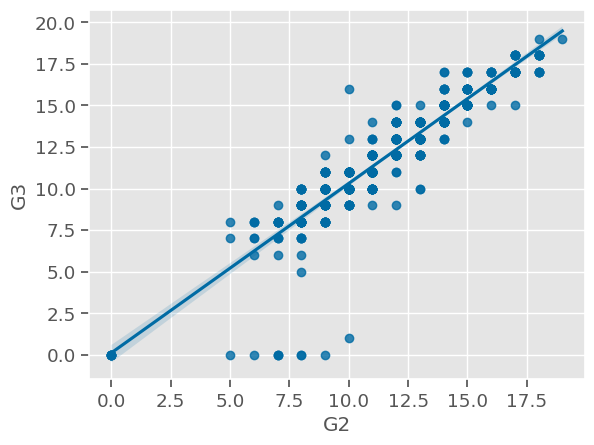

In [46]:
sns.regplot(data=plot_df, x='G2',y='G3');

- We can see a very clear pattern between G2 and G3. Except for the few 0's, all of the other values show a very strong correlation between G2 and G3, which makes sense. 
- How well you did at math last year is going to be a very good indicator in math next year.


### Absences


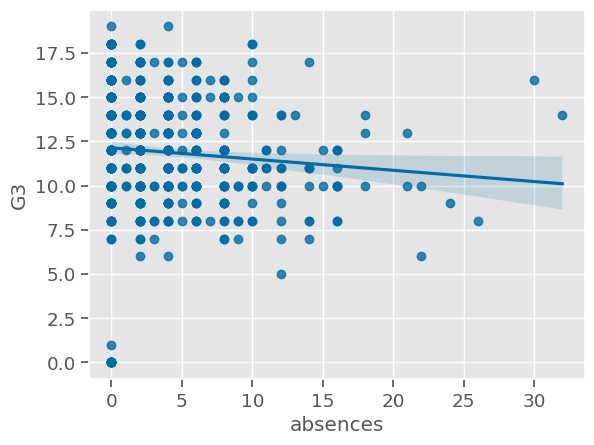

In [47]:
sns.regplot(data=plot_df, x='absences',y='G3');

- Absences seem to have a relatively flat relationship when we view a linear regression line summarizing the relationship.

- Instead of a normal linear regression, we can apply a Lowess regression (Locally Weighted Smoothed Scatterplot). Where we will get a nonlinear curve summarizing the relationship over the length of the entire x-axis.

### G1

<AxesSubplot:xlabel='G1', ylabel='G3'>

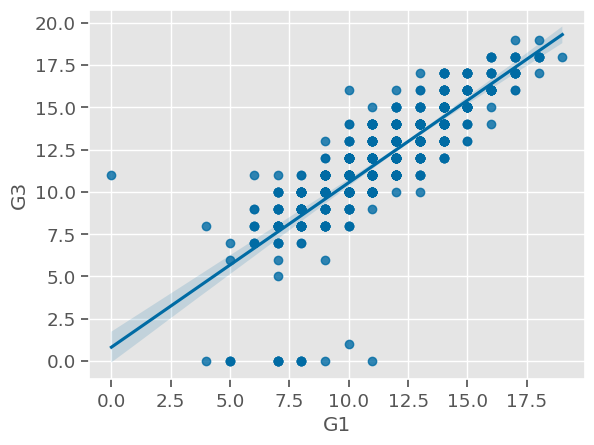

In [48]:
sns.regplot(data=plot_df, x='G1',y='G3')

- G1 is also a strong predictor, like G2.

#### Age

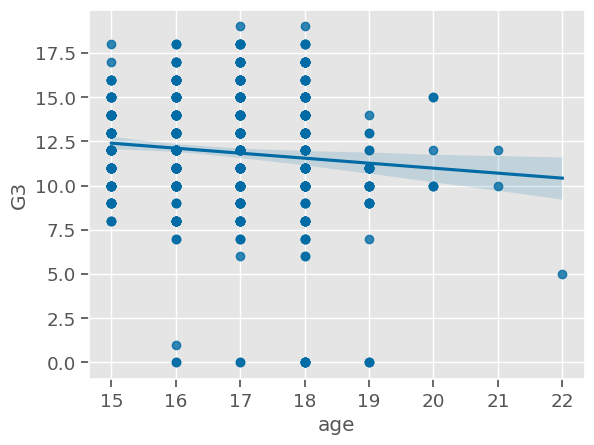

In [49]:
sns.regplot(data=plot_df, x='age',y='G3');

- Hmm, age has a more complicated and nonlinear relationship with our target. 
- Lets visualize the Lowess scatterplot for this feature.

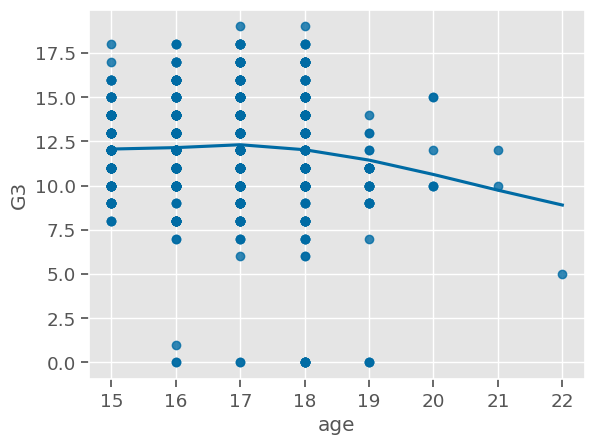

In [50]:
sns.regplot(data=plot_df, x='age',y='G3',lowess=True);

- It looks the lowess scatterplot is showing us the same thing as our linear scatterplot:
    - A very minor downward trend.
    
    

- If we treat the ages as groups and visualize the average grade for each age, we may be able to see the pattern more clearly.

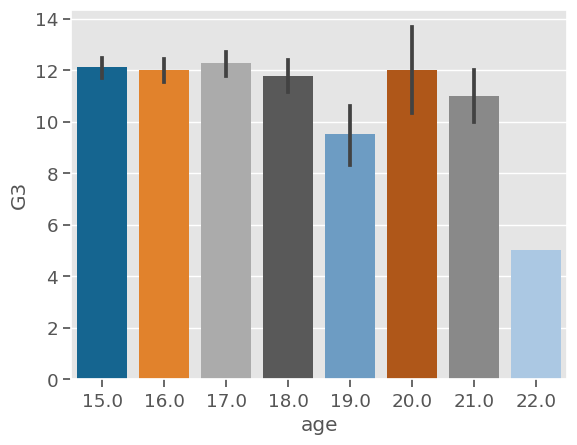

In [51]:
sns.barplot(data=plot_df, x='age',y='G3');

- It looks like there is a general pattern of older students performing worse in their 3rd year.
- This make sense, as someone who is 19 years old may have been held back previously or had some developmental issues that caused them to start school at an older age.
    - We don't really know, though! At least not with the tools we have applied thus far.

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 17.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 8.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='age', ylabel='G3'>

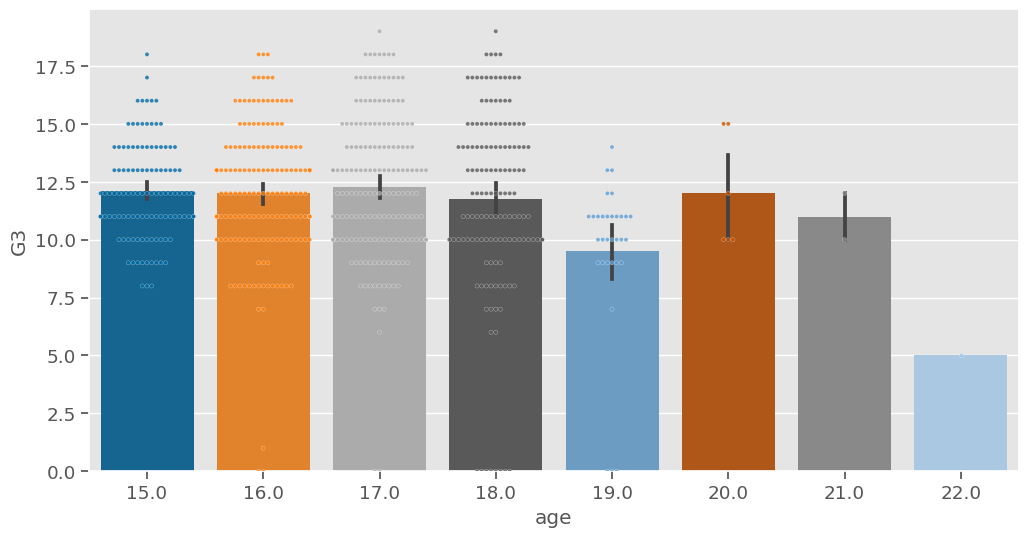

In [52]:
## making a larger figure for the swarmplot so it can show more markers
plt.figure(figsize=(12,6))
sns.swarmplot(data=plot_df, x='age',y='G3',size=3,edgecolor='white',
              linewidth=0.2, alpha=.8);
sns.barplot(data=plot_df, x='age',y='G3')#,palette='dark');

<AxesSubplot:xlabel='age', ylabel='G3'>

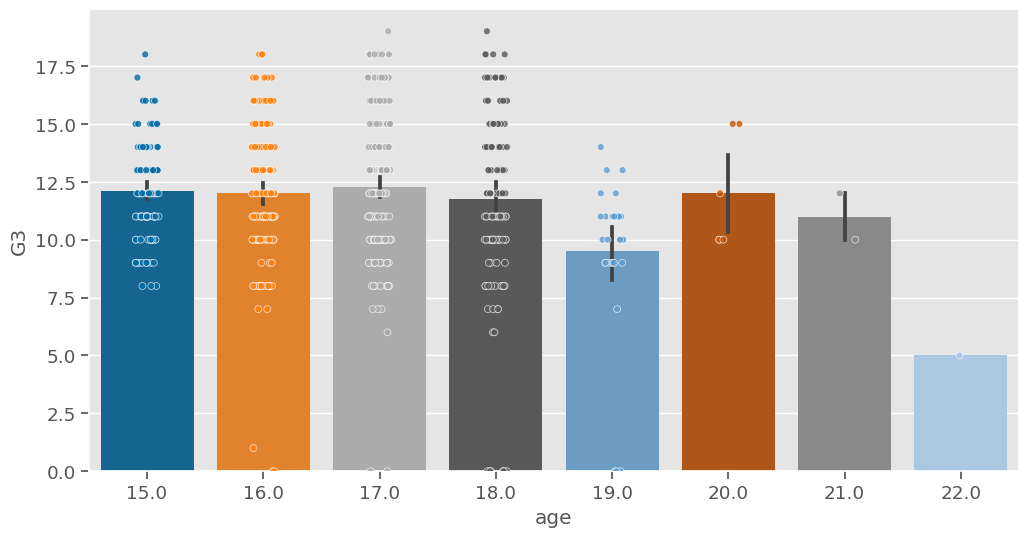

In [53]:
## making a larger figure for the swarmplot so it can show more markers
plt.figure(figsize=(12,6))
sns.stripplot(data=plot_df, x='age',y='G3',size=5,edgecolor='white',
              linewidth=0.5, alpha=.8);
sns.barplot(data=plot_df, x='age',y='G3')#,palette='dark');

###  Plotting trees

- We can select an individual tree from or random forest and visual its decision pathways using sklearn's plot_tree function.
- First let's slice out the first tree from the forest's .estimators_ and evaluate its performance. 

In [54]:
example_tree =  reg.estimators_[0]
example_tree

DecisionTreeRegressor(max_features=1.0, random_state=1657633780)

In [55]:
evaluate_regression(example_tree,X_train_df, y_train, X_test_df,y_test)

Training Data:	R^2= 0.88	RMSE= 1.16
Test Data:	R^2= 0.71	RMSE= 1.62


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


- We can see the first tree actually performed pretty well, with a similar R-squared score for training and test data. 
- Before we try to visualize the entire tree, let's find out how deep it grew. Large trees can be very difficult to visualize in 1 graph.


In [56]:
example_tree.get_depth()

12

- Our tree is 12 levels deep. Let's attempt to visualize the entire tree. 
- We will need to create a VERY large figure for this. Something way larger than any figure we would normally make. Let's try 40 inches by 20 inches.

# 📌**BOOKMARK 09/23/22 plot_tree In-Depth**

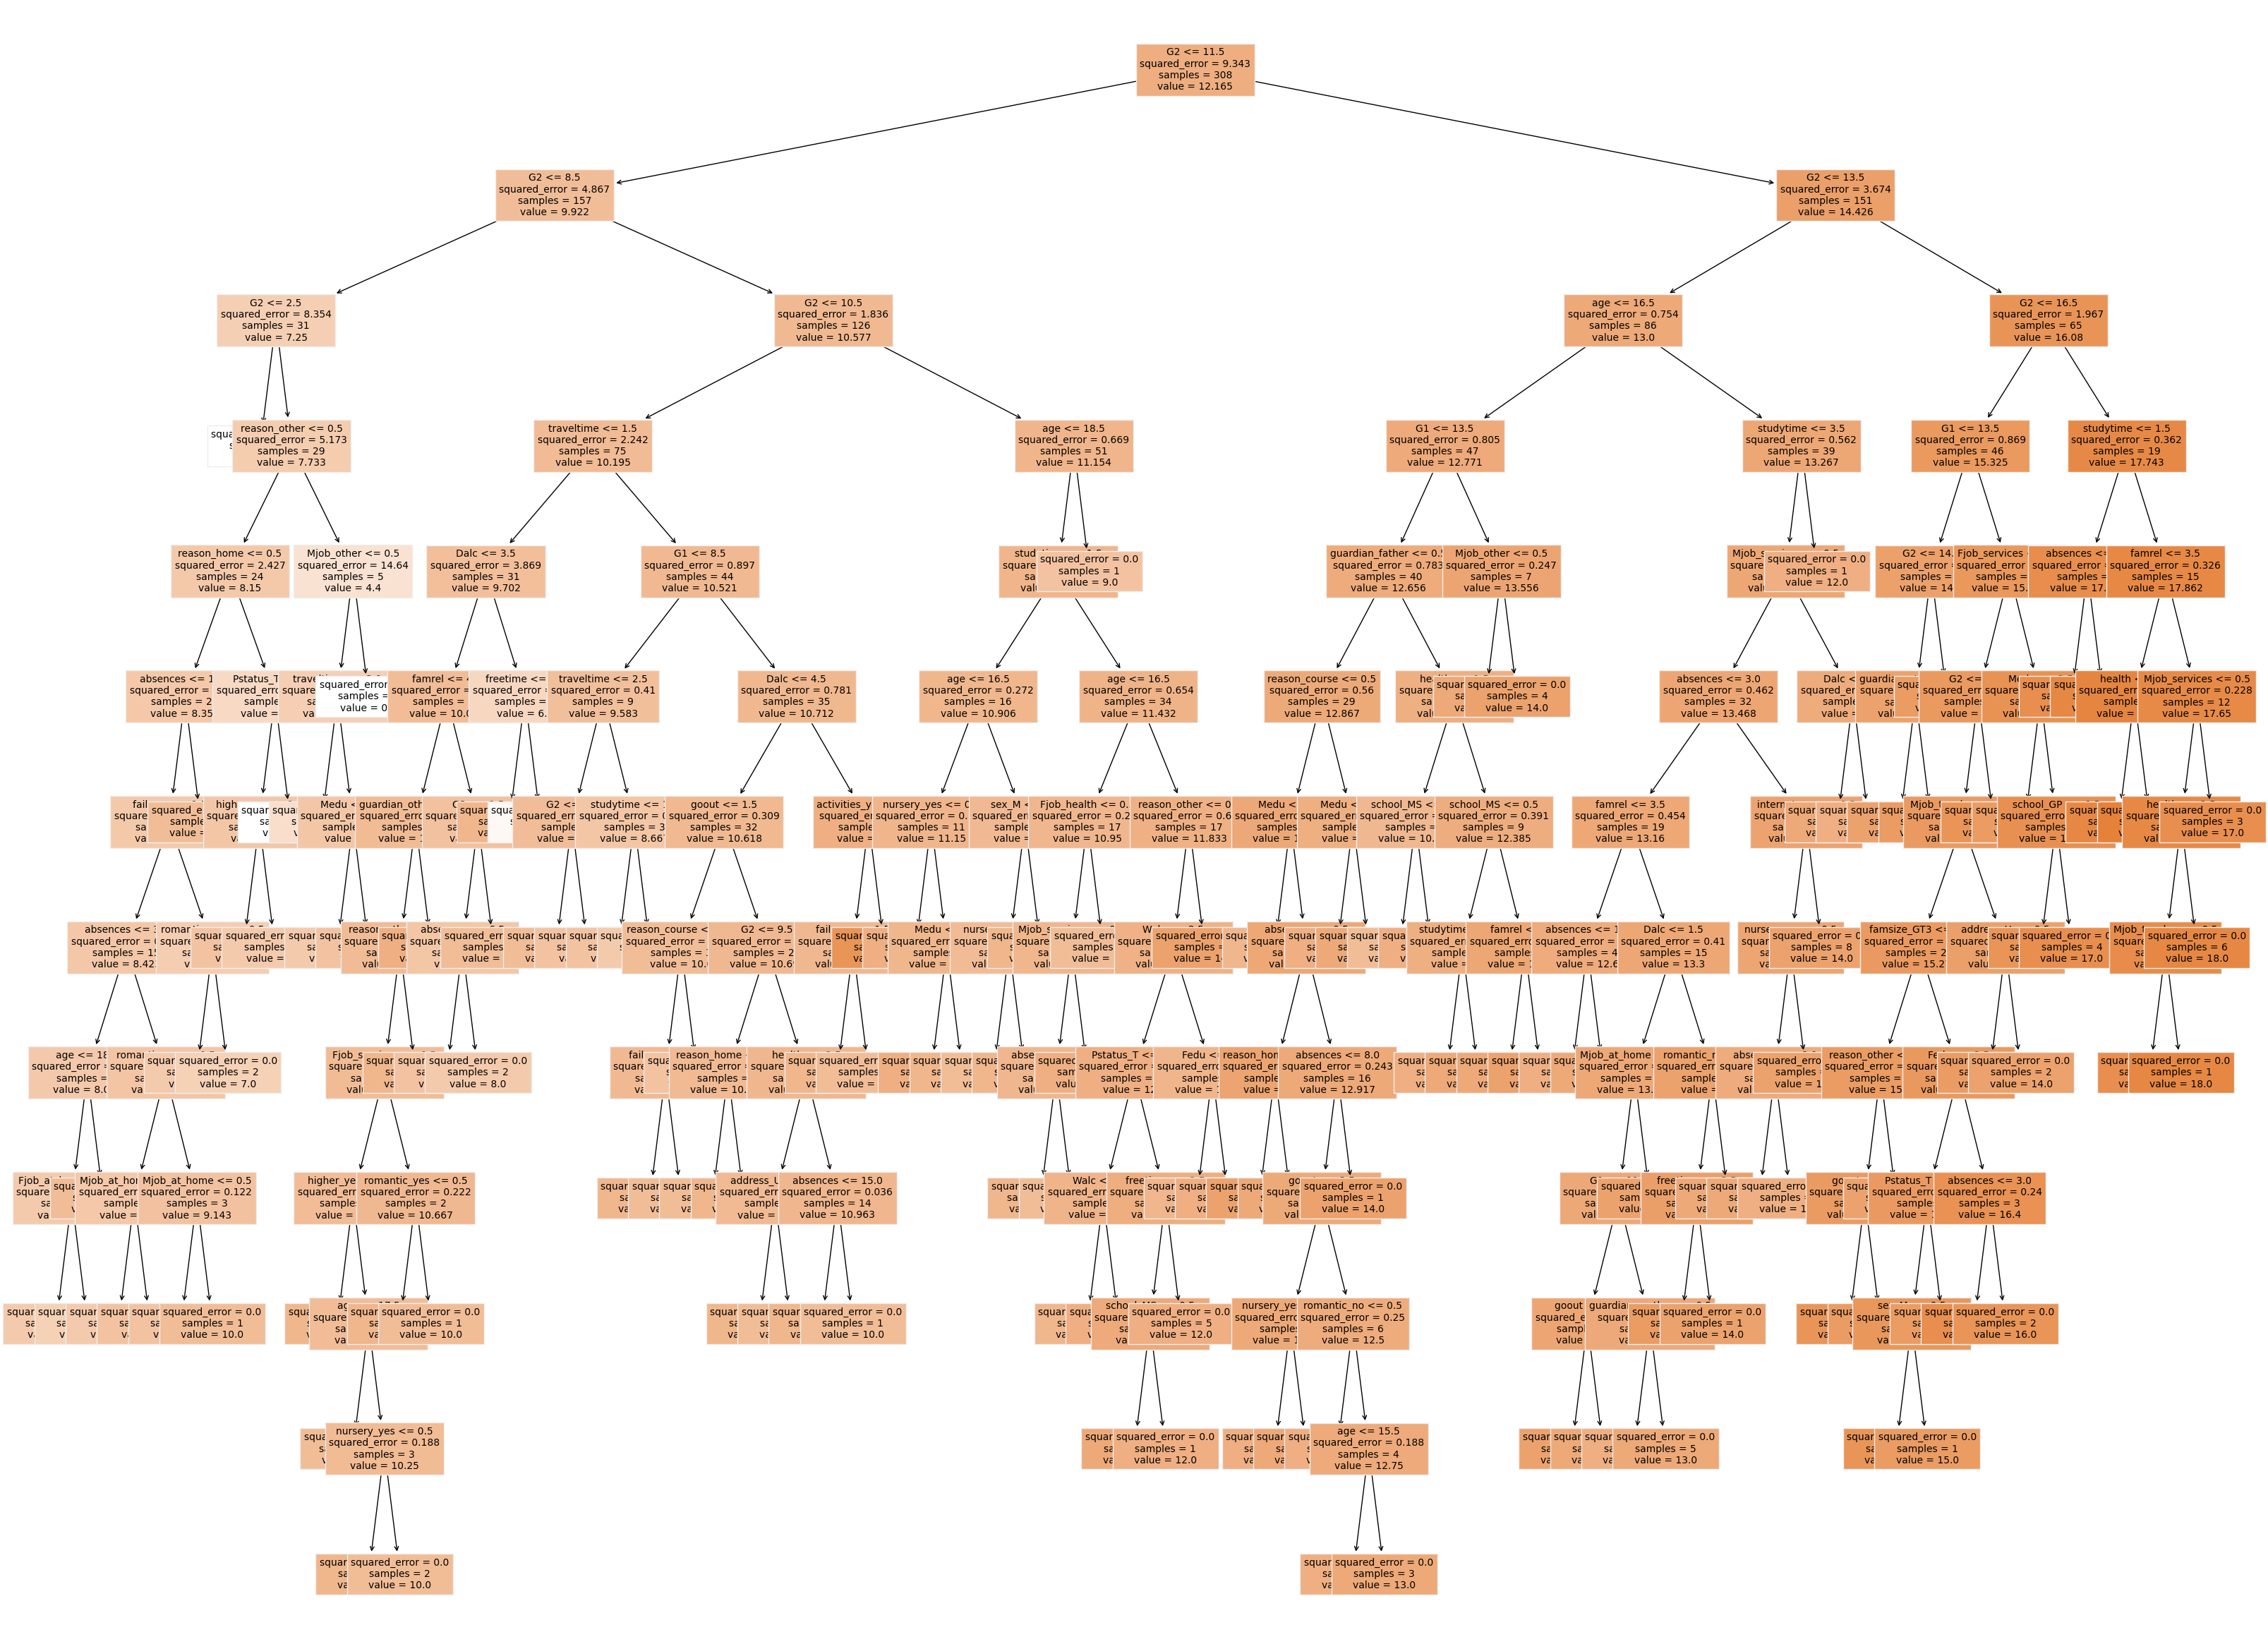

In [62]:
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(40,30))
plot_tree(example_tree, filled=True,feature_names=feature_names,ax=ax,
         fontsize=10);

fig.savefig('images/example_tree.png',dpi=300)

- There's a lot of information here, too much to easily fit in 1 visualization.

- Let's limit our plot_tree to only use a max_depth of 4

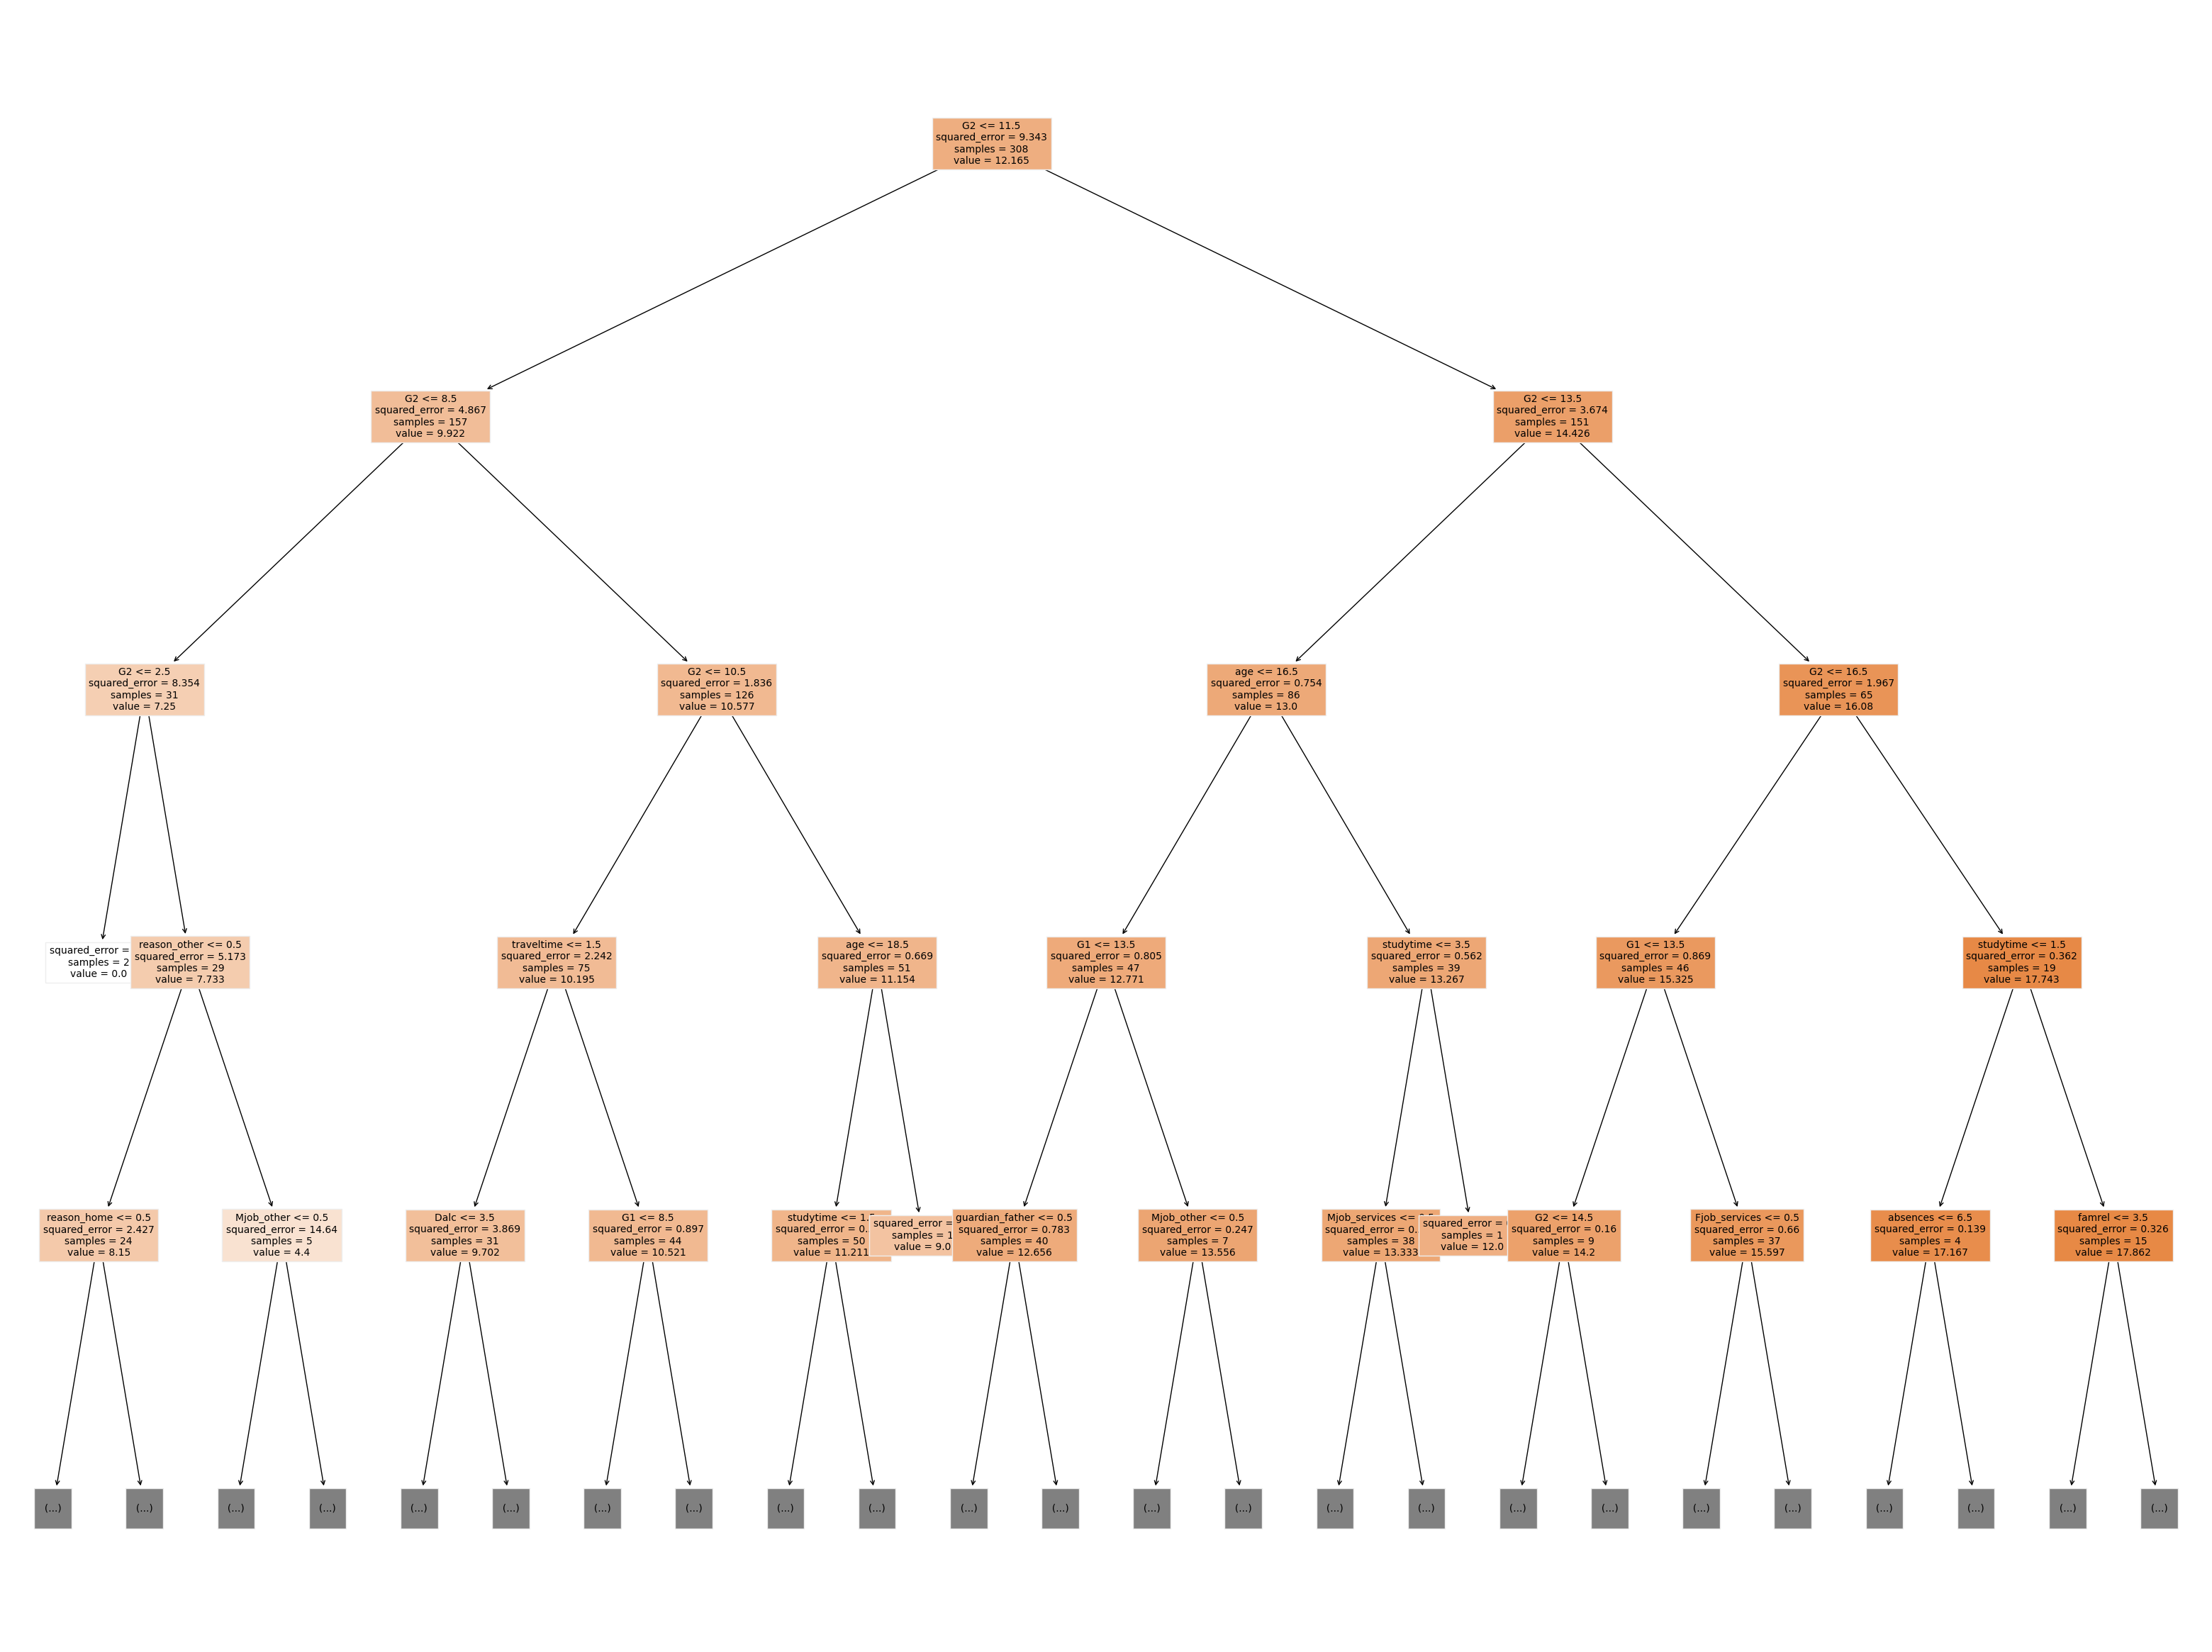

In [65]:
fig, ax = plt.subplots(figsize=(40,30))
plot_tree(example_tree, max_depth=4,filled=True,feature_names=feature_names,ax=ax,
         fontsize=10);

fig.savefig('images/example_tree_depth4.png',dpi=300)

<img src="./images/example_tree_depth4 g2.png">

### ORIGINAL CONTINUED [Pre 09/23/22]

>`NOTE TO BRENDA:` not sure how to best leverage this on the LP. Maybe take some zoomed-in screenshots to highlight the points below?

- Note: jupyter notebook will automatically shrink figures to fit inside the output window. 
- If you slowly double-click on the image, it should show you the larger version of the image. 

- You can always save the figure as a file first and open that manually, too!

In [58]:
fig.savefig('example_tree.png',dpi=300)

- If we examine the decision pathway (which starts at the top-center of the image. 
- We can see that the tree used G2 for many splits early on in the tree. 
- Remember: feature importance reflects how much the model used that feature to split the samples and predict the final grade. Therefore, it makes sense that we are seeing G2 being used a lot, since it was the single most important feature (by far).

## Task B: Modeling Without Previous Grades

- If we weren't sure that we should try removing G1 and G2 before, look at how much G2 is DOMINATING the feature importance. We can hardly see the other features. (and remember that feature importances must sum to 1).
    - Considering the business case considerations we discussed previously, this confirms that including G2 is not going to help us get a better understanding of which students perform better prior to year 1.

In [59]:
## Drop the G1 and G2 features from the x vars
drop_cols = ['G1','G2']
X_train_B = X_train_df.drop(columns=drop_cols)
X_test_B = X_test_df.drop(columns=drop_cols)
feature_names_B = X_train_B.columns
X_train_B

age  Medu  Fedu  traveltime  studytime  failures  famrel  freetime  \
54   15.0   3.0   3.0         1.0        1.0       0.0     5.0       3.0   
208  16.0   2.0   3.0         2.0        1.0       0.0     5.0       3.0   
23   16.0   2.0   2.0         2.0        2.0       0.0     5.0       4.0   
547  16.0   4.0   1.0         1.0        1.0       0.0     4.0       1.0   
604  18.0   1.0   1.0         3.0        2.0       1.0     4.0       4.0   
..    ...   ...   ...         ...        ...       ...     ...       ...   
410  17.0   2.0   2.0         1.0        2.0       0.0     4.0       3.0   
168  15.0   2.0   3.0         1.0        2.0       0.0     4.0       4.0   
401  18.0   4.0   3.0         1.0        3.0       0.0     5.0       4.0   
124  16.0   2.0   2.0         1.0        2.0       0.0     5.0       4.0   
538  16.0   2.0   2.0         1.0        3.0       0.0     4.0       3.0   

     goout  Dalc  Walc  health  absences  school_GP  school_MS  sex_F  sex_M  \
54     4.0   4.0   4.0     1.0       0.0        1.0        0.0    1.0    0.0   
208    3.0   1.0   1.0     3.0       0.0        1.0        0.0    0.0    1.0   
23     4.0   2.0   4.0     5.0       2.0        1.0        0.0    0.0    1.0   
547    2.0   2.0   1.0     2.0       0.0        0.0        1.0    0.0    1.0   
604    2.0   1.0   2.0     2.0       2.0        0.0        1.0    1.0    0.0   
..     ...   ...   ...     ...       ...        ...        ...    ...    ...   
410    4.0   1.0   3.0     4.0       0.0        1.0        0.0    1.0    0.0   
168    4.0   1.0   1.0     1.0       0.0        1.0        0.0    0.0    1.0   
401    5.0   2.0   3.0     5.0       0.0        1.0        0.0    0.0    1.0   
124    4.0   1.0   1.0     5.0       0.0        1.0        0.0    1.0    0.0   
538    3.0   2.0   2.0     5.0       2.0        0.0        1.0    1.0    0.0   

     address_R  address_U  famsize_GT3  famsize_LE3  Pstatus_A  Pstatus_T  \
54         0.0        1.0          0.0          1.0        1.0        0.0   
208        0.0        1.0          1.0          0.0        0.0        1.0   
23         0.0        1.0          0.0          1.0        0.0        1.0   
547        1.0        0.0          0.0          1.0        0.0        1.0   
604        0.0        1.0          1.0          0.0        0.0        1.0   
..         ...        ...          ...          ...        ...        ...   
410        0.0        1.0          1.0          0.0        0.0        1.0   
168        1.0        0.0          1.0          0.0        0.0        1.0   
401        0.0        1.0          1.0          0.0        0.0        1.0   
124        0.0        1.0          1.0          0.0        0.0        1.0   
538        1.0        0.0          0.0          1.0        0.0        1.0   

     Mjob_at_home  Mjob_health  ...  Fjob_services  Fjob_teacher  \
54            0.0          0.0  ...            0.0           0.0   
208           0.0          0.0  ...            0.0           0.0   
23            0.0          0.0  ...            0.0           0.0   
547           0.0          0.0  ...            0.0           0.0   
604           1.0          0.0  ...            1.0           0.0   
..            ...          ...  ...            ...           ...   
410           0.0          0.0  ...            1.0           0.0   
168           1.0          0.0  ...            1.0           0.0   
401           0.0          0.0  ...            0.0           0.0   
124           0.0          0.0  ...            0.0           0.0   
538           0.0          0.0  ...            0.0           0.0   

     reason_course  reason_home  reason_other  reason_reputation  \
54             0.0          0.0           1.0                0.0   
208            0.0          1.0           0.0                0.0   
23             0.0          0.0           0.0                1.0   
547            0.0          0.0           1.0                0.0   
604            1.0          0.0           0.0     

Training Data:	R^2= 0.90	RMSE= 1.06
Test Data:	R^2= 0.34	RMSE= 2.47


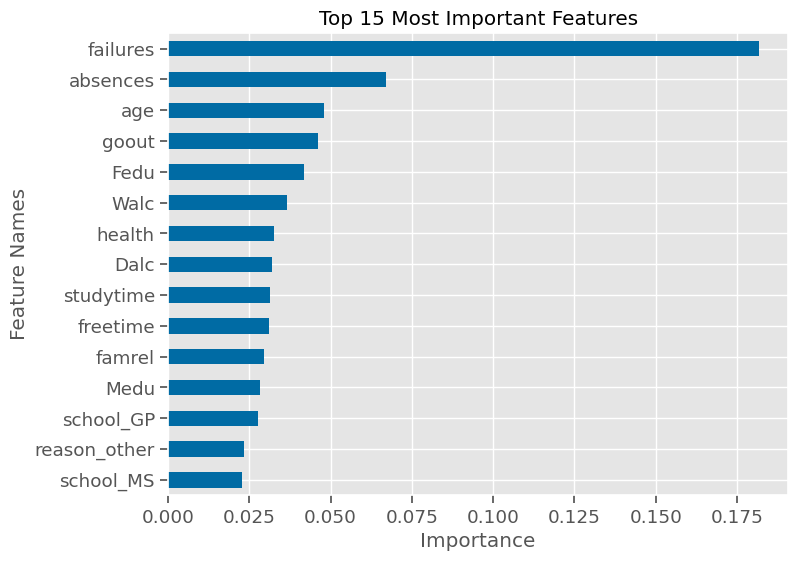

In [60]:
reg_B = RandomForestRegressor()
reg_B.fit(X_train_B, y_train)
evaluate_regression(reg_B, X_train_B, y_train, X_test_B,y_test)

## Saving the feature importances
importances = get_importances(reg_B, sort=True, ascending=False)
plot_importance(importances, top_n=15);

- Now that we have removed G2 and G1, we see a couple of significant changes in our results:
    1. that many more features are showing visible degrees of importance than before.
    2. That our model's performance has decreased dramatically without those features.
        - Our testing R-squared plummeted from .71 to .35
    

### Quick EDA For Top Features (without G1&G2)

- Let's visualize the 3 most important features (that we did not already visualize for our previous model.

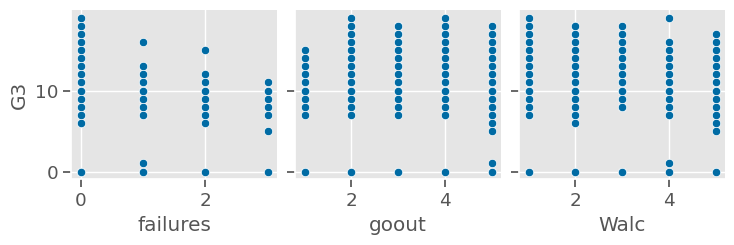

In [61]:
plot_cols = ['failures', 'goout', 'Walc']


sns.pairplot(data=plot_df, x_vars=plot_cols,y_vars="G3")

        
### Caveats about Built-In Feature Importance

- Also from the [Scikit-Learn RandomForest Documentation on Feature Importance](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=randomforest#sklearn.ensemble.RandomForestClassifier.feature_importances_):

- " Warning: impurity-based feature importances can be misleading for high cardinality features (many unique values). See sklearn.inspection.permutation_importance as an alternative."
- In other words, model-based feature importance is biased towards valuing features with many values.

## Permutation Importance (Beyond Built-In Importances)

- Scikit-learn has a tool called [permutation importance](https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-feature-importance) that will calculate feature importance, without the issues discussed above. 

- The function will take our model and our features and it will repeat the modeling for each feature.
    - One at a time, for each feature, it will shuffle all of the rows JUST IN THAT ONE FEATURE and repeat the modeling process.
    - The idea is that we are scrambling/destroying that features relationship to our target.

- Then, it examines which feature caused the biggest decrease in the model's performance, and it uses this information to determine the "permutation importance"



In [62]:
from sklearn.inspection import permutation_importance
## Permutation importance takes a fit mode and test data. 
r = permutation_importance(reg_B, X_train_B, y_train,n_repeats =5)
r.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [63]:
## can make the mean importances into a series
permutation_importances = pd.Series(r['importances_mean'],index=X_train_B.columns,
                           name = 'permutation importance')
permutation_importances = permutation_importances.sort_values(ascending=False)
permutation_importances

failures             0.441592
Fedu                 0.104488
absences             0.102938
age                  0.095789
school_GP            0.091263
studytime            0.085659
goout                0.078346
school_MS            0.070598
Walc                 0.059128
Medu                 0.053494
Dalc                 0.044291
health               0.042383
higher_yes           0.038880
freetime             0.038516
famrel               0.034821
reason_other         0.026694
higher_no            0.021441
Mjob_teacher         0.021132
traveltime           0.019216
Fjob_teacher         0.015778
schoolsup_yes        0.014098
schoolsup_no         0.012842
sex_F                0.012796
sex_M                0.012391
reason_reputation    0.012047
activities_no        0.012029
reason_home          0.011743
Mjob_other           0.010899
Mjob_at_home         0.010830
address_R            0.010584
activities_yes       0.010161
reason_course        0.010047
Fjob_other           0.009520
Fjob_servi

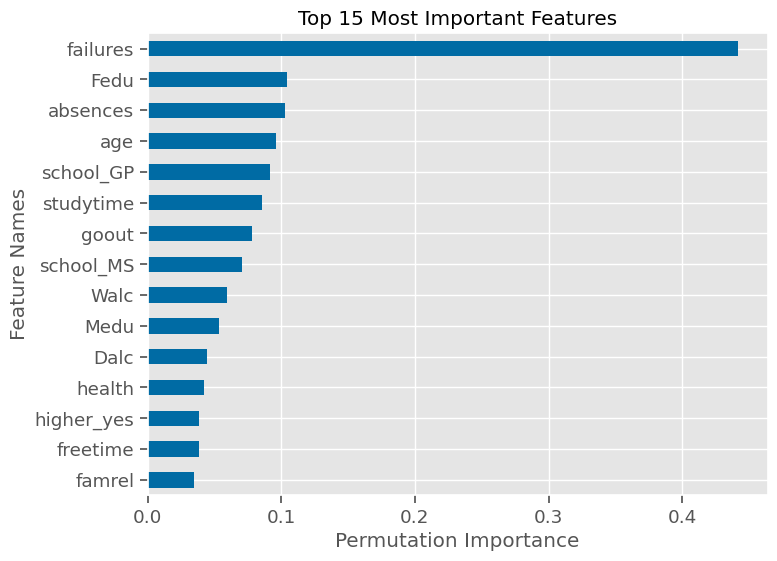

In [64]:
ax = plot_importance(permutation_importances,top_n=15)
ax.set(xlabel='Permutation Importance');
# ax.

   
>What is different about the features that permutation importance ranked as the most important vs the built-in importances?


### Easier Comparisons - Color Coordination

- We want to keep track of the top 5 important features from the random forest as we visualize the permutation importances. 

- We can do this by creating a dictionary with each feature name as the keys and the corresponding color as the value. 

>- So if we wanted to color code the top 5 features as green, we first need a list of those top 5 features, which we can get from the sorted importances

In [65]:
## color -coding top 5 bars
highlight_feats = importances.sort_values(ascending=True).tail(5).index
highlight_feats

Index(['Fedu', 'goout', 'age', 'absences', 'failures'], dtype='object')

 -  Next, we will create our dictionary by looping through the importances' index and for each feature, add the feature name as the key and the value will be:
     - green if the feature is in our `highlight_feats` list 
     - otherwise blue.
     
 - We could use a for loop to accomplish this. 
 - We can also use a dictionary comprehensions. Which works very similarly to a list comprehension, except:
     - We use {} instead of []
     - We must provide a k:v at the beginning of the comprehensions.

In [66]:
## for-loop way
colors_dict = {}

for col in importances.index:
    if col in highlight_feats:
        colors_dict[col] = 'green'
    else:
        colors_dict[col] = 'blue'
        
colors_dict

{'failures': 'green',
 'absences': 'green',
 'age': 'green',
 'goout': 'green',
 'Fedu': 'green',
 'Walc': 'blue',
 'health': 'blue',
 'Dalc': 'blue',
 'studytime': 'blue',
 'freetime': 'blue',
 'famrel': 'blue',
 'Medu': 'blue',
 'school_GP': 'blue',
 'reason_other': 'blue',
 'school_MS': 'blue',
 'Mjob_teacher': 'blue',
 'higher_yes': 'blue',
 'traveltime': 'blue',
 'higher_no': 'blue',
 'Fjob_teacher': 'blue',
 'schoolsup_yes': 'blue',
 'activities_no': 'blue',
 'reason_reputation': 'blue',
 'reason_home': 'blue',
 'reason_course': 'blue',
 'schoolsup_no': 'blue',
 'Mjob_other': 'blue',
 'Mjob_at_home': 'blue',
 'Mjob_services': 'blue',
 'Fjob_services': 'blue',
 'famsup_no': 'blue',
 'famsup_yes': 'blue',
 'activities_yes': 'blue',
 'Fjob_other': 'blue',
 'sex_F': 'blue',
 'nursery_no': 'blue',
 'sex_M': 'blue',
 'famsize_LE3': 'blue',
 'internet_no': 'blue',
 'address_R': 'blue',
 'Fjob_at_home': 'blue',
 'famsize_GT3': 'blue',
 'guardian_mother': 'blue',
 'romantic_no': 'blue',
 

In [67]:
## Dict comprehension way
colors_dict = {col:'green' if col in highlight_feats else 'blue' for col in importances.index}
colors_dict

{'failures': 'green',
 'absences': 'green',
 'age': 'green',
 'goout': 'green',
 'Fedu': 'green',
 'Walc': 'blue',
 'health': 'blue',
 'Dalc': 'blue',
 'studytime': 'blue',
 'freetime': 'blue',
 'famrel': 'blue',
 'Medu': 'blue',
 'school_GP': 'blue',
 'reason_other': 'blue',
 'school_MS': 'blue',
 'Mjob_teacher': 'blue',
 'higher_yes': 'blue',
 'traveltime': 'blue',
 'higher_no': 'blue',
 'Fjob_teacher': 'blue',
 'schoolsup_yes': 'blue',
 'activities_no': 'blue',
 'reason_reputation': 'blue',
 'reason_home': 'blue',
 'reason_course': 'blue',
 'schoolsup_no': 'blue',
 'Mjob_other': 'blue',
 'Mjob_at_home': 'blue',
 'Mjob_services': 'blue',
 'Fjob_services': 'blue',
 'famsup_no': 'blue',
 'famsup_yes': 'blue',
 'activities_yes': 'blue',
 'Fjob_other': 'blue',
 'sex_F': 'blue',
 'nursery_no': 'blue',
 'sex_M': 'blue',
 'famsize_LE3': 'blue',
 'internet_no': 'blue',
 'address_R': 'blue',
 'Fjob_at_home': 'blue',
 'famsize_GT3': 'blue',
 'guardian_mother': 'blue',
 'romantic_no': 'blue',
 

<AxesSubplot:>

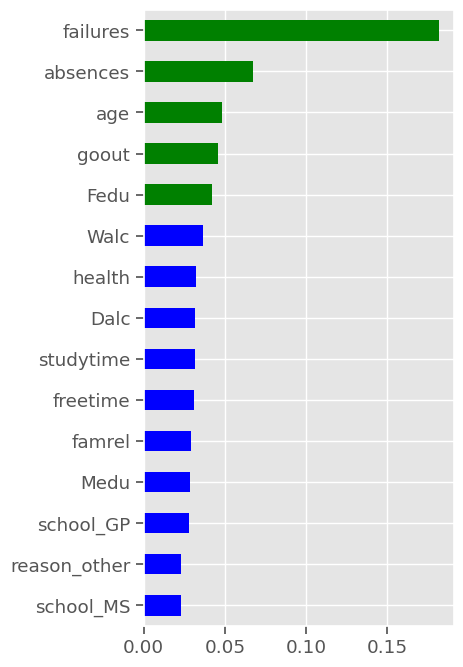

In [68]:
plot_vals = importances.sort_values().tail(15)
plot_vals.plot(kind='barh',color=plot_vals.index.map(colors_dict), figsize=(4,8))

- We were able to selectively color the bars!

    - But we want to keep the same shade of blue that is used by default with our current style.

    - We can extract the current color from a bar by finding where it is located inside of the Axis. 

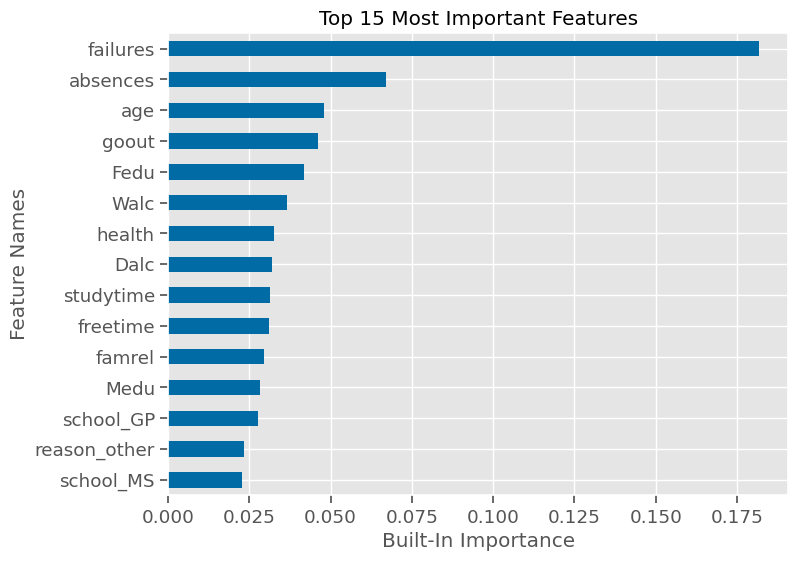

In [69]:
ax = plot_importance(importances,top_n=15)
ax.set(xlabel='Built-In Importance');

- Axes have a .containers list that will contain the collections of visual elements used.

In [70]:
ax.containers

[<BarContainer object of 15 artists>]

- We need the bars from the barcontainer

In [71]:
## get the bar container
bars = ax.containers[0]
bars

<BarContainer object of 15 artists>

- Each bar in our figure can be found in this object.
    - bars are technically an instance of a "Rectangle".

In [72]:
bar = bars[0]
bar

- Use OOP .get_ methods to extract the faceolor of the bar.

In [73]:
bar_color = bar.get_facecolor()
bar_color

(0.0, 0.4196078431372549, 0.6431372549019608, 1.0)

- The color is return as a list of RGBA values.
    - Unfortunately, this type of color is not compatible with pandas .plot().
    

In [74]:
## Dict comprehension way - testing using RGBA color
colors_dict = {col:'green' if col in highlight_feats else bar_color for col in importances.index}
colors_dict

{'failures': 'green',
 'absences': 'green',
 'age': 'green',
 'goout': 'green',
 'Fedu': 'green',
 'Walc': (0.0, 0.4196078431372549, 0.6431372549019608, 1.0),
 'health': (0.0, 0.4196078431372549, 0.6431372549019608, 1.0),
 'Dalc': (0.0, 0.4196078431372549, 0.6431372549019608, 1.0),
 'studytime': (0.0, 0.4196078431372549, 0.6431372549019608, 1.0),
 'freetime': (0.0, 0.4196078431372549, 0.6431372549019608, 1.0),
 'famrel': (0.0, 0.4196078431372549, 0.6431372549019608, 1.0),
 'Medu': (0.0, 0.4196078431372549, 0.6431372549019608, 1.0),
 'school_GP': (0.0, 0.4196078431372549, 0.6431372549019608, 1.0),
 'reason_other': (0.0, 0.4196078431372549, 0.6431372549019608, 1.0),
 'school_MS': (0.0, 0.4196078431372549, 0.6431372549019608, 1.0),
 'Mjob_teacher': (0.0, 0.4196078431372549, 0.6431372549019608, 1.0),
 'higher_yes': (0.0, 0.4196078431372549, 0.6431372549019608, 1.0),
 'traveltime': (0.0, 0.4196078431372549, 0.6431372549019608, 1.0),
 'higher_no': (0.0, 0.4196078431372549, 0.6431372549019608

In [75]:
## this will error!
try:
    plot_vals = importances.sort_values().tail(15)
    plot_vals.plot(kind='barh',color=plot_vals.index.map(colors_dict), figsize=(4,8))
except Exception as e:
    print('ERROR: ', e)
    

ERROR:  Expected tuple, got str


- If convert from the RGBA tuple to a string representation of the color, we can use it by converting it with functions from matplotlib's color module.

- To use the color module, we need to import matplotlib itself instead of matplotlib.pyplot.

- We will then use the function matplotlib.colors.rgb2hex to get the color as a string.


In [76]:
import matplotlib as mpl
#https://matplotlib.org/stable/api/colors_api.html#module-matplotlib.colors

In [77]:
bar_color_hex = mpl.colors.rgb2hex(bar_color)
bar_color_hex

'#006ba4'

- For more information on the various forms of colors for matplotlib, check out their documentation on [Specifying Colors](https://matplotlib.org/stable/tutorials/colors/colors.html)

In [78]:
## Dict comprehension way - testing using RGBA color
colors_dict = {col:'green' if col in highlight_feats else bar_color_hex for col in importances.index}
colors_dict

{'failures': 'green',
 'absences': 'green',
 'age': 'green',
 'goout': 'green',
 'Fedu': 'green',
 'Walc': '#006ba4',
 'health': '#006ba4',
 'Dalc': '#006ba4',
 'studytime': '#006ba4',
 'freetime': '#006ba4',
 'famrel': '#006ba4',
 'Medu': '#006ba4',
 'school_GP': '#006ba4',
 'reason_other': '#006ba4',
 'school_MS': '#006ba4',
 'Mjob_teacher': '#006ba4',
 'higher_yes': '#006ba4',
 'traveltime': '#006ba4',
 'higher_no': '#006ba4',
 'Fjob_teacher': '#006ba4',
 'schoolsup_yes': '#006ba4',
 'activities_no': '#006ba4',
 'reason_reputation': '#006ba4',
 'reason_home': '#006ba4',
 'reason_course': '#006ba4',
 'schoolsup_no': '#006ba4',
 'Mjob_other': '#006ba4',
 'Mjob_at_home': '#006ba4',
 'Mjob_services': '#006ba4',
 'Fjob_services': '#006ba4',
 'famsup_no': '#006ba4',
 'famsup_yes': '#006ba4',
 'activities_yes': '#006ba4',
 'Fjob_other': '#006ba4',
 'sex_F': '#006ba4',
 'nursery_no': '#006ba4',
 'sex_M': '#006ba4',
 'famsize_LE3': '#006ba4',
 'internet_no': '#006ba4',
 'address_R': '#006ba4

<AxesSubplot:>

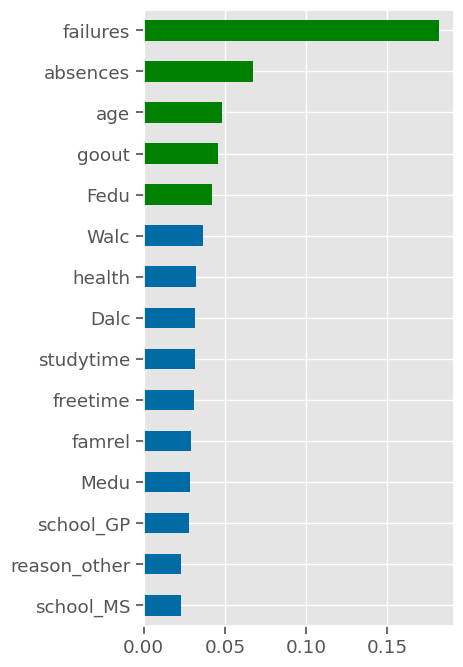

In [79]:
## this will error!
plot_vals = importances.sort_values().tail(15)
plot_vals.plot(kind='barh',color=plot_vals.index.map(colors_dict), figsize=(4,8))

In [80]:
def get_color_dict(importances, color_rest='#006ba4' , color_top='green', 
                   top_n=7):
    ## color -coding top 5 bars
    highlight_feats = importances.sort_values(ascending=True).tail(top_n).index
    colors_dict = {col: color_top if col in highlight_feats else color_rest for col in importances.index}
    return colors_dict

In [81]:
colors_top7 = get_color_dict(importances, top_n=7)
colors_top7

{'failures': 'green',
 'absences': 'green',
 'age': 'green',
 'goout': 'green',
 'Fedu': 'green',
 'Walc': 'green',
 'health': 'green',
 'Dalc': '#006ba4',
 'studytime': '#006ba4',
 'freetime': '#006ba4',
 'famrel': '#006ba4',
 'Medu': '#006ba4',
 'school_GP': '#006ba4',
 'reason_other': '#006ba4',
 'school_MS': '#006ba4',
 'Mjob_teacher': '#006ba4',
 'higher_yes': '#006ba4',
 'traveltime': '#006ba4',
 'higher_no': '#006ba4',
 'Fjob_teacher': '#006ba4',
 'schoolsup_yes': '#006ba4',
 'activities_no': '#006ba4',
 'reason_reputation': '#006ba4',
 'reason_home': '#006ba4',
 'reason_course': '#006ba4',
 'schoolsup_no': '#006ba4',
 'Mjob_other': '#006ba4',
 'Mjob_at_home': '#006ba4',
 'Mjob_services': '#006ba4',
 'Fjob_services': '#006ba4',
 'famsup_no': '#006ba4',
 'famsup_yes': '#006ba4',
 'activities_yes': '#006ba4',
 'Fjob_other': '#006ba4',
 'sex_F': '#006ba4',
 'nursery_no': '#006ba4',
 'sex_M': '#006ba4',
 'famsize_LE3': '#006ba4',
 'internet_no': '#006ba4',
 'address_R': '#006ba4',
 

In [82]:
colors_top5 = get_color_dict(importances, top_n=5)
colors_top5

{'failures': 'green',
 'absences': 'green',
 'age': 'green',
 'goout': 'green',
 'Fedu': 'green',
 'Walc': '#006ba4',
 'health': '#006ba4',
 'Dalc': '#006ba4',
 'studytime': '#006ba4',
 'freetime': '#006ba4',
 'famrel': '#006ba4',
 'Medu': '#006ba4',
 'school_GP': '#006ba4',
 'reason_other': '#006ba4',
 'school_MS': '#006ba4',
 'Mjob_teacher': '#006ba4',
 'higher_yes': '#006ba4',
 'traveltime': '#006ba4',
 'higher_no': '#006ba4',
 'Fjob_teacher': '#006ba4',
 'schoolsup_yes': '#006ba4',
 'activities_no': '#006ba4',
 'reason_reputation': '#006ba4',
 'reason_home': '#006ba4',
 'reason_course': '#006ba4',
 'schoolsup_no': '#006ba4',
 'Mjob_other': '#006ba4',
 'Mjob_at_home': '#006ba4',
 'Mjob_services': '#006ba4',
 'Fjob_services': '#006ba4',
 'famsup_no': '#006ba4',
 'famsup_yes': '#006ba4',
 'activities_yes': '#006ba4',
 'Fjob_other': '#006ba4',
 'sex_F': '#006ba4',
 'nursery_no': '#006ba4',
 'sex_M': '#006ba4',
 'famsize_LE3': '#006ba4',
 'internet_no': '#006ba4',
 'address_R': '#006ba4

- `NOTE TO BRENDA`: I can either explain using plot_kws and `**kwargs` in depth (it will also explain how seaborn works) OR i could change the function below to use a less flexble approach.

In [83]:
# def plot_importance_color(importances, top_n=None,  figsize=(8,6), color_dict=None,
#                    plot_kws = {}):
#     # sorting with asc=false for correct order of bars
    
#     if top_n==None:
#         ## sort all features and set title
#         plot_vals = importances.sort_values()
#         title = "All Features - Ranked by Importance"

#     else:
#         ## sort features and keep top_n and set title
#         plot_vals = importances.sort_values().tail(top_n)
#         title = f"Top {top_n} Most Important Features"

#     ## plotting top N importances
#     if color_dict is not None:
#         ## Getting color list and saving to plot_kws
#         colors = plot_vals.index.map(color_dict)
#         plot_kws.update({'color':colors})
        

#     ax = plot_vals.plot(kind='barh', figsize=figsize,**plot_kws)
#     ax.set(xlabel='Importance', 
#            ylabel='Feature Names', 
#            title=title)
    
#     ## return ax in case want to continue to update/modify figure
#     return ax

In [84]:
# new 09/21/22

def plot_importance_color(importances, top_n=None,  figsize=(8,6), 
                          color_dict=None):
    
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"

    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"


    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors)
        
    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind='barh', figsize=figsize)
        
    # set titles and axis labels
    ax.set(xlabel='Importance', 
           ylabel='Feature Names', 
           title=title)
    
    ## return ax in case want to continue to update/modify figure
    return ax

<AxesSubplot:title={'center':'Top 20 Most Important Features'}, xlabel='Importance', ylabel='Feature Names'>

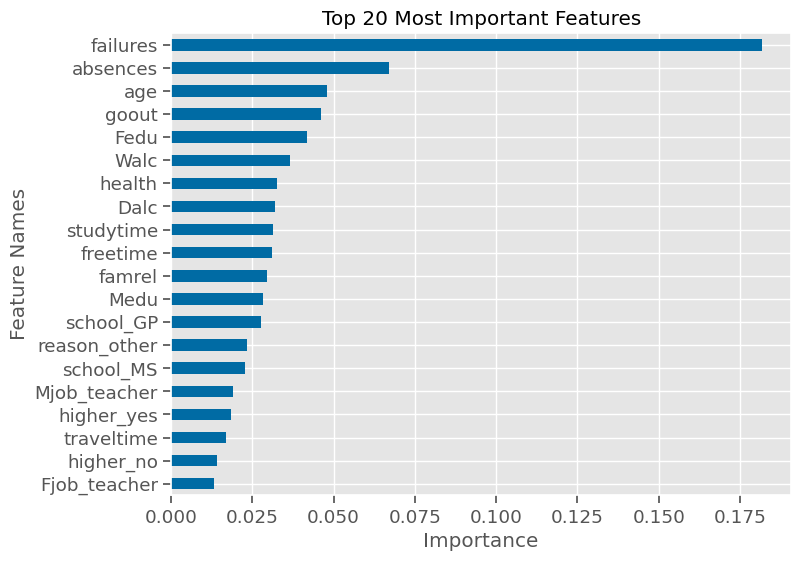

In [85]:
plot_importance_color(importances, color_dict=None,top_n=20)

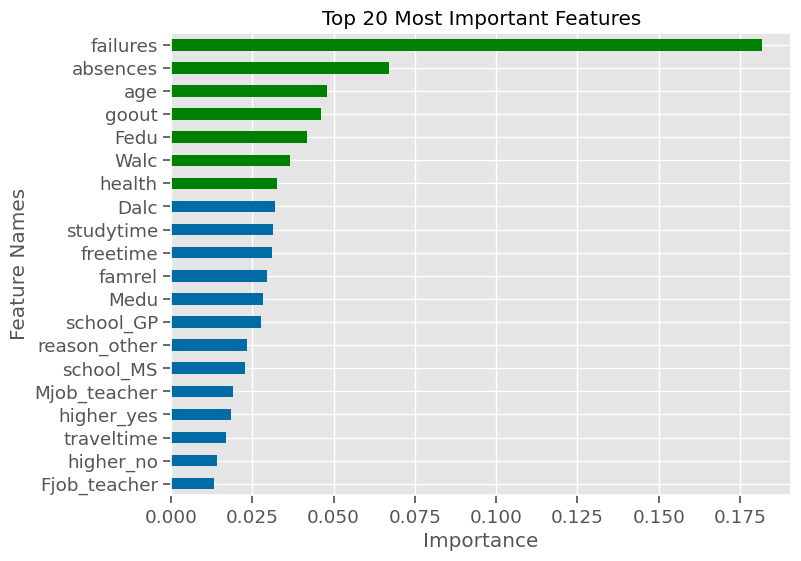

In [86]:
plot_importance_color(importances, color_dict=colors_top7,top_n=20);

Text(0.5, 0, 'PERMUTATION IMPORTANCE')

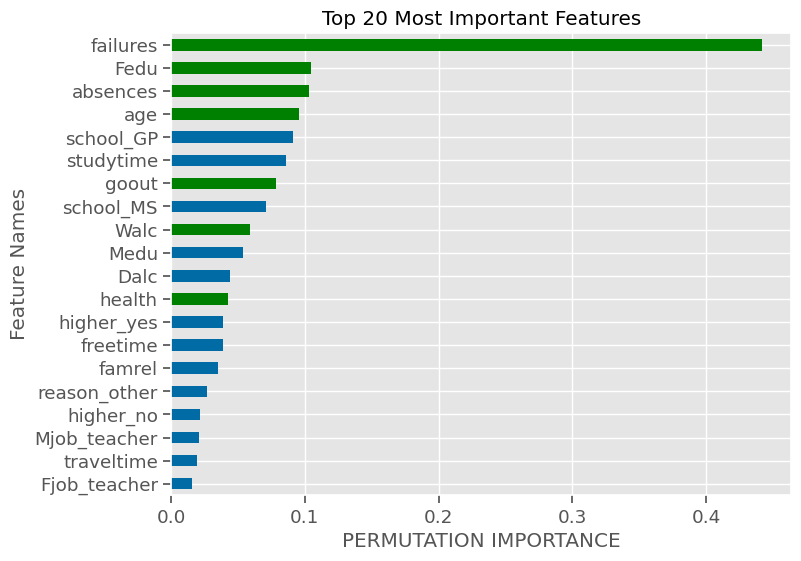

In [87]:
ax = plot_importance_color(permutation_importances,color_dict=colors_top7,top_n=20);
ax.set_xlabel("PERMUTATION IMPORTANCE")

- Comparing the random forest importances and the permutation importances  above, we can see that:
    - The first 2 most important features are the same in both. (absences and failures)
    - Notice that our built-in importances below had the following features as the next most important:
        - age
        - Fedu
        - Walc
        - goout
        - studytime
    - Compare this to permutation importance, which had the following features:
        - Fedu
        - school_GP
        - age
        - studytime
        - goout
        - School_MS
        
     

#### `NOTE TO BRENDA ABOUT VIZ ABOVE`


>- I wanted to make these side by side subplots for the comparison, but wanted to modify our function to accept an ax to plot onto (just like pandas or seaborn do)
    - Example function below

In [99]:
# # TEMP - EXAMPLE FOR BRENDA
# def plot_importance_color_ax(importances, top_n=None,  figsize=(8,6),
#                              ax=None,
#                           color_dict=None,
#                    plot_kws = {}):
#     # sorting with asc=false for correct order of bars
    
#     if top_n==None:
#         ## sort all features and set title
#         plot_vals = importances.sort_values()
#         title = "All Features - Ranked by Importance"

#     else:
#         ## sort features and keep top_n and set title
#         plot_vals = importances.sort_values().tail(top_n)
#         title = f"Top {top_n} Most Important Features"

#     ## plotting top N importances
#     if color_dict is not None:
#         ## Getting color list and saving to plot_kws
#         colors = plot_vals.index.map(color_dict)
#         plot_kws.update({'color':colors})
        
    
#     ax = plot_vals.plot(kind='barh', ax=ax, figsize=figsize,**plot_kws)
#     ax.set(xlabel='Importance', 
#            ylabel='Feature Names', 
#            title=title)
    
#     ## return ax in case want to continue to update/modify figure
#     return ax

In [89]:
# new 09/21/22

def plot_importance_color_ax(importances, top_n=None,  figsize=(8,6), 
                          color_dict=None, ax=None):
    
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"

    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"


    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors, ax=ax)
        
    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind='barh', figsize=figsize, ax=ax)
        
    # set titles and axis labels
    ax.set(xlabel='Importance', 
           ylabel='Feature Names', 
           title=title)
    
    ## return ax in case want to continue to update/modify figure
    return ax

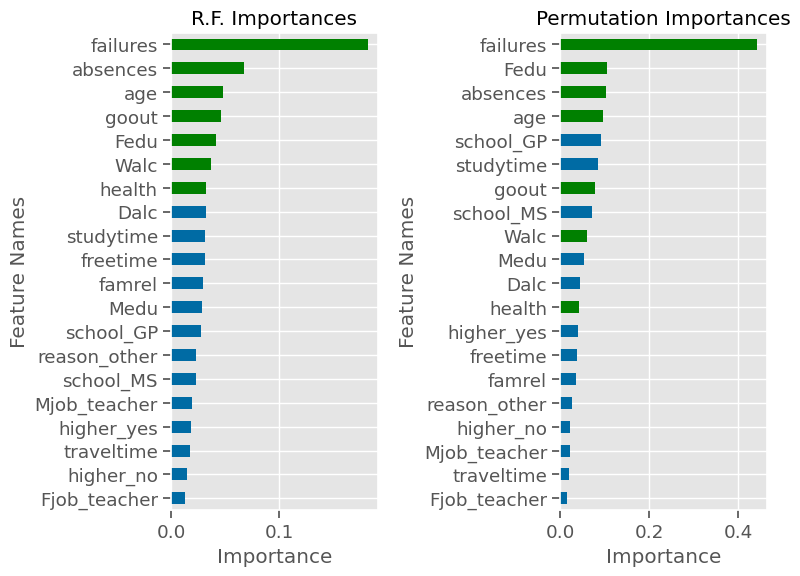

In [90]:
fig, axes = plt.subplots(ncols=2,figsize=(20,8))
n = 20
plot_importance_color_ax(importances, top_n=n, ax=axes[0],
                         color_dict=colors_top7)
plot_importance_color_ax(permutation_importances, top_n=n, ax=axes[1],
                         color_dict=colors_top7)

axes[0].set(title='R.F. Importances')
axes[1].set(title='Permutation Importances')
fig.tight_layout()

   
>Now, what is different about the features that permutation importance ranked as the most important vs the built-in importances?

- school_GP, school_MS are categorical features! The random forest importances is biased towards using considering continuous features to be more important.  There were no categorical features in the top 7 r.f. importances.

- Whereas permutation Importance judged all features without a bias towards continuous features. It found 2 out of of the top 7 most important features to be categorical.


## Advantages/Disadvantages of Permutation Importance

- Advantages:
    - Model agnostic (can be used on any model)
    - Avoids the biases of built-in feature importances.
- Disadvantages:
    - Only positive values (don't know which way each feature pushes the model's predictions)

## EDA Follow-Up

- Now that we have some categorical features appearing in our permutation importances, let's try to visualize those.
    - We will want to return to the original dataframe that still had the categorical features as a single column.

### Reason

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 31.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 12.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='reason', ylabel='G3'>

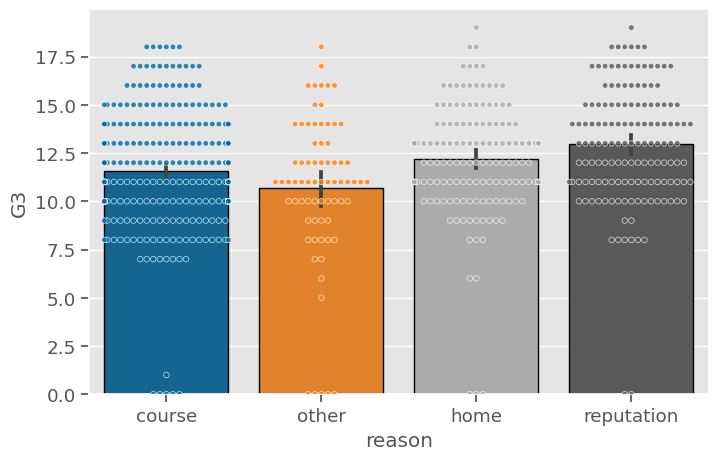

In [91]:
plt.figure(figsize=(8,5))

sns.swarmplot(data=df, x='reason',y='G3',size=4,edgecolor='white',
              linewidth=0.5, alpha=.8);
sns.barplot(data=df, x='reason',y='G3',edgecolor='black',
            linewidth=1)

- We can see that reason_course has a slighty lower means than some of the groups, but not strikingly so. 
- The mean is heavily influenced by outlier values, so let's visualize the median instead by adding `estimator=np.median` to our barplot.

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 31.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 12.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


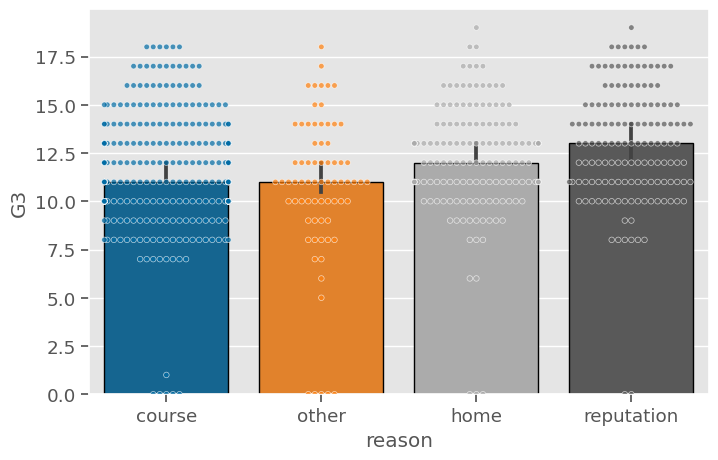

In [92]:
plt.figure(figsize=(8,5))

sns.swarmplot(data=df, x='reason',y='G3',size=4,edgecolor='white',
              linewidth=0.5, alpha=.7);
sns.barplot(data=df, x='reason',y='G3',edgecolor='black',
            linewidth=1,estimator=np.median);

#### mjob

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 23.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 38.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 9.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


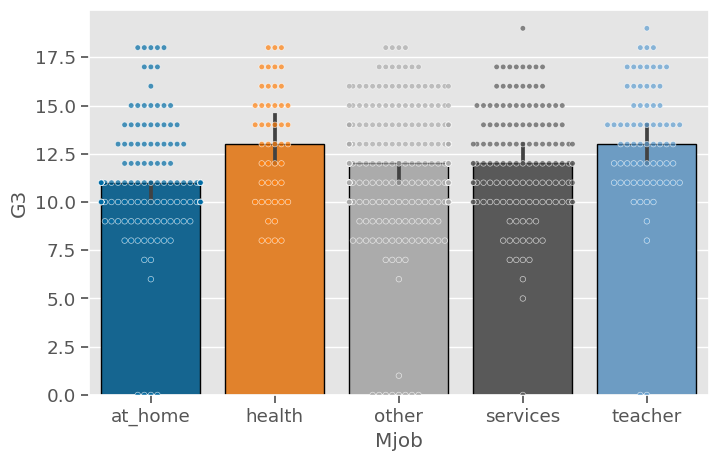

In [93]:
plt.figure(figsize=(8,5))

sns.swarmplot(data=df, x='Mjob',y='G3',size=4,edgecolor='white',
              linewidth=0.5, alpha=.7);
sns.barplot(data=df, x='Mjob',y='G3',edgecolor='black',
            linewidth=1,estimator=np.median);

- We can see that the student's mother's job is has a relationship with our target. "At_home" has the lowest median grade out of all the maternal job categories.

## Beyond sklearn

- In an upcoming lesson, we will introduce additional packages designed to explain machine learning models with greater detail and nuance.

### Summary
- In this lesson we learned about feature importance and its advantages and disadvantages. We also implemented a scikit-learn tool that calculated similar importances, but in a less biased way.
- Next lesson we will revisit linear regression coefficients with sklearn.


# END OF LESSON ?

## Selecting Our Best Model `UPDATE TO MATCH LIN REG ADDED BACK`

- We will continue to explore the results from our original model that included G1 and G2. While this may not be the best explanatory tool due to the dominance of G2, it is a good model overall in terms of R-squared/RMSE. Compared to our second model task, in which we only had a test R-squared =.11
- If our model is terrible at predicting our target, we cannot really trust its insights.

-  In the next lesson, we will explore converting this task to a classification problem to identify at-risk students. If can achieve a classification model without G1 and G2 that has decent metrics, then that will be our best path forward.


### Saving Models & Objects with `joblib`


- We will create a dictionary of variables we want to export to use in a subsequent notebook/analysis. It will include
    
- While pickle is a common tool used for this, the joblib package has become increasing popular. Scikit-learn now promotes joblib files as the best way to save models. 

    - Here is the [section of the User Guide on "Serializing models"](https://scikit-learn.org/stable/modules/model_persistence.html#python-specific-serialization) where they demonstrate using joblib.
    
    
- To make it easy to remember which variable was which, we will save the data and model into a dictionary first.
    - We will save our:
        - Training and test data
        - Our preprocessing column transformer
        - Our model
    - Then we will save the dictionary to a joblib file.
    

In [94]:
## saving variables for next lesson/notebook
import joblib

## creating a dictionary of all of the variables to save for later
export = {'X_train':X_train_df,
         'y_train': y_train,
         'X_test':X_test_df, 
         "y_test": y_test,
         'preprocessor':preprocessor,
         'RandomForest':reg}

joblib.dump(export, 'random_forest_l01.joblib')

['random_forest_l01.joblib']

- to load in the joblib in the future, we will just use `joblib.load` and can then slice out the keys from our dictionary to create new variables.

In [95]:
import joblib

loaded = joblib.load('random_forest_l01.joblib')
loaded.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'RandomForest'])

In [96]:
X_train_df = loaded['X_train']
y_train = loaded['y_train']
X_test_df = loaded['X_test']
y_test = loaded['y_test']
preprocessor = loaded['preprocessor']
loaded_model = loaded['RandomForest']

- Importantly, the variables are all fully intact, previous fitting and all.

Training Data:	R^2= 0.98	RMSE= 0.52
Test Data:	R^2= 0.83	RMSE= 1.26


<AxesSubplot:title={'center':'Top 15 Most Important Features'}, xlabel='Importance', ylabel='Feature Names'>

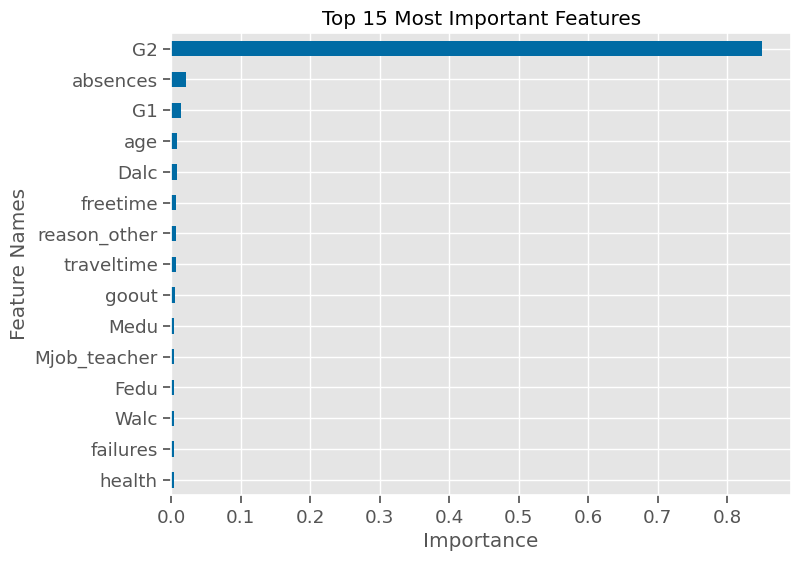

In [97]:
evaluate_regression(loaded_model,X_train_df, y_train, X_test_df,y_test)
loaded_importances = get_importances(loaded_model)
plot_importance_color(loaded_importances,top_n=15,color_dict=None)

## ADD TO FINAL LESSON?

### Function Docstrings

- 

In [98]:
def plot_importance_color(importances, top_n=None,  figsize=(8,6), 
                          color_dict=None):
    
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"

    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"


    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors)
        
    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind='barh', figsize=figsize)
        
    # set titles and axis labels
    ax.set(xlabel='Importance', 
           ylabel='Feature Names', 
           title=title)
    
    ## return ax in case want to continue to update/modify figure
    return ax



def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):
    """Extracts and returns model.feature_importances_ 
    
    Args:
        model (sklearn estimator): a fit model with .feature_importances_
        feature_names (list/array): the names of the features. Default=None.
                                    If None, extract feature names from model
        name (str): name for the panda's Series. Default is 'Feature Importance'
        sort (bool): controls if importances are sorted by value. Default=False.
        ascending (bool): ascending argument for .sort_values(ascending= ___ )
                            Only used if sort===True.
                            
    Returns:
        Pandas Series with Feature Importances
        """
    
    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_
        
    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)

    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)
        
    return importances




def plot_importance_color(importances, top_n=None,  figsize=(8,6), color_dict=None,
                   plot_kws = {}):
    """Plots series of feature importances
    
    Args:
        importances (pands Series): importance values to plot
        top_n (int): The # of features to display (Default=None). 
                        If None, display all.
                        otherwise display top_n most important
                        
        figsize (tuple): figsize tuple for .plot
        color_dict (dict): dict with index values as keys with color to use as vals
                            Uses series.index.map(color_dict).
        plot_kws (dict): additional keyword args accepted by panda's .plot
                            
    Returns:
        Axis: matplotlib axis
        """
    
    # sorting with asc=false for correct order of bars
    
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"

    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"

    ## plotting top N importances
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        plot_kws.update({'color':colors})
        

    ax = plot_vals.plot(kind='barh', figsize=figsize,**plot_kws)
    ax.set(xlabel='Importance', 
           ylabel='Feature Names', 
           title=title)
    
    ## return ax in case want to continue to update/modify figure
    return ax




def get_color_dict(importances, color_rest='#006ba4' , color_top='green', 
                   top_n=7):
    """Constructs a color dictionary where the index of the top_n values will be 
    colored with color_top and the rest will be colored color_rest"""
    ## color -coding top 5 bars
    highlight_feats = importances.sort_values(ascending=True).tail(top_n).index
    colors_dict = {col: color_top if col in highlight_feats else color_rest for col in importances.index}
    return colors_dict